<img src="https://radar.community.uaf.edu/wp-content/uploads/sites/667/2021/03/HydroSARbanner.jpg" width="100%" />

<br>
<font size="6"> <b>FIER Daily Flood Forecasting Code</b><img style="padding: 7px" src="https://radar.community.uaf.edu/wp-content/uploads/sites/667/2021/03/UAFLogo_A_647.png" width="170" align="right"/></font>

<br>
<font size="4"> <b> Franz J Meyer, University of Alaska Fairbanks</b> <br>
</font>

This notebooks is developing an algorithm to generate daily flood inundation predictions using time series of Sentinel-1 RTC data and GEOGLoWs river runoff forecasts. 
    
The workflow utilizes information available in the fierpy <a href="https://github.com/SERVIR/fierpy">fierpy</a> GitHub repository.
<hr>



TO DO: mode selection before rotation, change NN modes

# Load Python Libraries

In [1]:
%matplotlib widget
import fierpy
from fier_local import reof as freof
from fier_local import sel_best_fit
from ipyfilechooser import FileChooser
import ipywidgets as widgets
from IPython.display import Markdown
from IPython.display import display
import glob
import json # for loads
from keras import backend as K
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import opensarlab_lib as asfn
import os
from osgeo import gdal, osr
import pandas as pd
from pathlib import Path
import rioxarray as rxr
import re
import seaborn as sns
from sklearn.model_selection import KFold
import sklearn.metrics as metrics
from sklearn.preprocessing import MinMaxScaler
import sys
import xarray as xr
# from ipyfilechooser import FileChooser
from tensorflow import keras
import tensorflow as tf
import warnings
# %%capture
# from pathlib import Path
import shutil
# from IPython.display import Markdown
# from IPython.display import display
# %matplotlib widget
# from ipyfilechooser import FileChooser
# import matplotlib.pyplot as plt 
plt.rcParams.update({'font.size': 12})
# import opensarlab_lib as asfn
asfn.jupytertheme_matplotlib_format()
from typing import Tuple
import pickle
import psutil
import time
import tracemalloc

ModuleNotFoundError: No module named 'matplotlib'

**Some functions to deal with geotiffs and arrays**

In [2]:
# This function gets the dates of each file from their filename
def get_dates(dir_path, prefix):
    dates = []
    pths = list(dir_path.glob(f'{prefix}.tif*'))

    for p in pths:
        date_regex = '\d{8}'
        date = re.search(date_regex, str(p))
        if date:
            dates.append(date.group(0))
    return dates

# Normalize the datasets
# Define the normalization function
def normalize(arr):
    # Calculate the maximum value in the slice
    max_val = np.max(arr)
    min_val = np.min(arr)
    # Normalize the slice by dividing each element by the maximum value
    normalized_arr = (arr - min_val)/(max_val - min_val)
    return normalized_arr

# Append all entries of the dataset dictionnary. Used for when we skip SAR VH and SAR VH & VV
def append_all(dic, name, to_append):
        for key1, nested_level1 in dic.items():
            for key2, nested_level2 in nested_level1.items():
                nested_level2[f'{name}'].append(to_append)  
                
                
# Used to grab the coordinates of the AOI defined by each geotiff               
def get_coordinates_from_geotiff_bbox(geotiff_path):
    dataset = gdal.Open(geotiff_path)

    # Get the GeoTransform to convert pixel coordinates to geographical coordinates
    transform = dataset.GetGeoTransform()

    # Get the raster size (number of rows and columns)
    cols = dataset.RasterXSize
    rows = dataset.RasterYSize

    # Get the four corner points in pixel coordinates
    corners = [(0, 0), (cols, 0), (cols, rows), (0, rows)]

    # Calculate the longitude (X) and latitude (Y) of each corner
    corner_coordinates = []
    for corner in corners:
        lon = transform[0] + corner[0] * transform[1] + corner[1] * transform[2]
        lat = transform[3] + corner[0] * transform[4] + corner[1] * transform[5]

        # Get the spatial reference system of the dataset
        srs = osr.SpatialReference()
        srs.ImportFromWkt(dataset.GetProjection())

        # Create a coordinate transformation object
        target_srs = osr.SpatialReference()
        target_srs.ImportFromEPSG(4326)  # EPSG code for WGS84
        transform_obj = osr.CoordinateTransformation(srs, target_srs)

        # Transform the coordinates to WGS84 (latitude and longitude)
        lon, lat, _ = transform_obj.TransformPoint(lon, lat)

        corner_coordinates.append((lat, lon))
        
    corner_coordinates = np.array(corner_coordinates)
    boundaries = np.array([[np.min(corner_coordinates[:,1]), np.min(corner_coordinates[:,0])],
                           [np.max(corner_coordinates[:,1]), np.max(corner_coordinates[:,0])]])

    return boundaries


# Used to grab the centerpoint coordinates of a geotiff
def get_centerpoint_coordinates(tif_file):
    dataset = gdal.Open(str(tif_file))
    
    # Get the geospatial transform
    geotransform = dataset.GetGeoTransform()
    
    # Get the image size
    width = dataset.RasterXSize
    height = dataset.RasterYSize
    
    # Calculate the center pixel coordinates
    center_x = geotransform[0] + (geotransform[1] * width + geotransform[2]) / 2
    center_y = geotransform[3] + (geotransform[4] * height + geotransform[5]) / 2
    
    # Create a spatial reference object for EPSG:4326
    src_srs = osr.SpatialReference()
    src_srs.ImportFromEPSG(4326)
    
    # Create a spatial reference object for the TIF file
    dataset_srs = osr.SpatialReference()
    dataset_srs.ImportFromWkt(dataset.GetProjection())
    
    # Create a coordinate transformation object
    coord_transform = osr.CoordinateTransformation(dataset_srs, src_srs)
    
    # Transform the center point coordinates to EPSG:4326
    lon, lat, _ = coord_transform.TransformPoint(center_x, center_y)
    
    return lat, lon


**Function to create animated plots**

In [3]:
# Function that plots one image at a time
def update_plot(frame, dataset, type_file):
    # Extract the 2D slice corresponding to the current time step
    current_slice = dataset[frame, :, :]
    
    # Clear the previous plot
    plt.clf()
    
    # Depending on if your input iw water mask or RTC, the colormap changes
    if type_file == 'Water_Masks':
        plt.imshow(current_slice, cmap='Blues', interpolation="none", vmin=0, vmax=1.2)
    else:
        # Plot the 2D slice
        plt.imshow(current_slice, cmap='viridis', vmin = dataset.mean() - dataset.std(), vmax = dataset.mean() + dataset.std())
    
    # Add a title and other plot decorations (optional)
    plt.colorbar()
    
    # Add the date as a subtitle
    current_date = str(dataset.time[frame].values)[:10]  # Assuming time is in datetime format
    plt.text(0.5, 1.01, f'Date: {current_date}', transform=plt.gca().transAxes,
             ha='center', va='bottom', fontsize=10)
 

# Function to create the animated gifs
def animate(dataset, fps, name, type_file):
    
    if os.path.exists(pathfig/f"{name}.gif"):
        print("GIF already exists.")
    else:
        # Create the animation
        fig = plt.figure()
        num_frames = dataset.shape[0]-1 # Because of Python's indexing and HTML indexing difference
        ani = animation.FuncAnimation(fig, update_plot, frames=num_frames, fargs=(dataset,type_file,), blit=False)

        # To show the animation in Jupyter Notebook (optional)

        from IPython.display import HTML
        HTML(ani.to_jshtml())

        # Save the animation as a GIF
        ani.save(pathfig/f"{name}.gif", writer='pillow', fps=fps)
        plt.close(ani._fig)
        plt.close(fig)

**Function to calculate the fits between data, discharge and precipitations, with a Neural Network**

In [4]:
def find_best_fit_nn(var, reof_ds, dataset, filetype, namefig):
    
    # Custom loss function
    def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 
    
    # Get rid of the annoying warning that we should use datasets for optimized keras operations
    tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

    # Create a list that will host the best models
    models = []

    # Define the neural network architecture. We are using ReLu according to Chang et al. (2023), 
    # with a linear output layer because it reduces the outliers and stabilized the fit.
    def create_model():
        model = keras.Sequential()
        model.add(keras.layers.Dense(units = 64, activation = 'relu', input_shape=(1,)))
        model.add(keras.layers.Dense(units = 64, activation = 'relu'))
        model.add(keras.layers.Dense(units = 64, activation = 'relu'))
        model.add(keras.layers.Dense(units = 64, activation = 'sigmoid'))
        model.add(keras.layers.Dense(units = 64, activation = 'relu'))
        model.add(keras.layers.Dense(units = 64, activation = 'relu'))
        model.add(keras.layers.Dense(units = 1, activation = 'linear'))
        model.compile(loss=root_mean_squared_error, optimizer='adam', metrics=['accuracy'])
        return model

    # Create a dictionnary to store statistics of each loop
    fit_dict = dict()
    dict_keys = ['fit_r2','pred_r','pred_rmse']

    # Generate sample data
    #hindcast_var = (var-var.min())/(var.max()-var.min())
    hindcast_var = var # KNICELY - this might be a problem; assigns the same reference point, doesn't copy. Need to know what 'var' is and if it changes. 
    
    # Reconstructed dataset 
    recon_da = np.zeros((dataset.shape))

    # Loop through temporal modes to determine the regression between them and variable
    for mode in reof_ds.mode.values:
        
        print(f'Computing mode {mode}')
        #hindcast_rtcp = (
        #    reof_ds.temporal_modes[:,mode-1] - reof_ds.temporal_modes[:,mode-1].min())/(reof_ds.temporal_modes[:,mode-1].max() - reof_ds.temporal_modes[:,mode-1].min())
        hindcast_rtcp = reof_ds.temporal_modes[:,mode]

        # Set up K-fold cross-validation
        k = 3
        kf = KFold(n_splits=k)

        # Perform K-fold cross-validation and evaluate the models
        best_model = None
        best_score = np.inf

        for train_index, val_index in kf.split(hindcast_var):
            
            # Initialize the scaler
            X_scaler = MinMaxScaler()
            Y_scaler = MinMaxScaler()
            
            # Select the data
            X_train, X_test = hindcast_var[train_index].values.reshape(-1,1), hindcast_var[val_index].values.reshape(-1,1)
            Y_train, Y_test = hindcast_rtcp[train_index].values.reshape(-1,1), hindcast_rtcp[val_index].values.reshape(-1,1)
            
            # Normalize the data
            X_train, X_test = X_scaler.fit_transform(X_train), X_scaler.transform(X_test)
            Y_train, Y_test = Y_scaler.fit_transform(Y_train), Y_scaler.transform(Y_test)

            # Fit the model to normalized data
            model = create_model()
            model.fit(X_train, Y_train, epochs=100, verbose=0)
            
            # Run the model predictions
            Y_test_pred = model.predict(X_test, verbose = 0)
            
            # Calculate the fit
            rmse = metrics.mean_squared_error(Y_test, Y_test_pred,squared=False)
            
            # Evaluate the model's score to the previous model's
            if rmse < best_score:
                best_score = rmse
                best_model = model

        # Redefine the scalers to avoid inheritance issues
        X_scaler = MinMaxScaler()
        Y_scaler = MinMaxScaler()       
        
        # Normalize the entire dataset
        X_normalized = X_scaler.fit_transform(hindcast_var.values.reshape(-1, 1))
        Y_normalized = Y_scaler.fit_transform(hindcast_rtcp.values.reshape(-1, 1))
        
        # Train the best model on the entire dataset
        best_model.fit(X_normalized, Y_normalized, epochs=1000, batch_size=10, verbose=0)
        
        # Append the model in the list
        models.append(best_model)
        
        # Make predictions using the best model
        hindcast_rtcp_pred_normalized = best_model.predict(X_scaler.transform(hindcast_var.values.reshape(-1, 1)), verbose=0)

        # Inverse transform the predictions to the original scale
        hindcast_rtcp_pred = Y_scaler.inverse_transform(hindcast_rtcp_pred_normalized)

        # Plot the input dataset and the predicted dataset
        fig = plt.figure()
        plt.scatter(var, reof_ds.temporal_modes[:,mode], label='Data')
        plt.scatter(var, hindcast_rtcp_pred, label='Model')
        plt.title(f"Mode {mode} NN fit for {namefig}")
        plt.legend()
        fig.savefig(pathfig/f"{namefig}/hindcast_{filetype}_{namefig}_mode_{mode}.png")
        plt.close()
            
        # Convert to dataarray
        hindcast_rtcp_pred_dataarray = var.copy()
        hindcast_rtcp_pred_dataarray.values = hindcast_rtcp_pred[:, 0]

        # Add to the reconstructed dataset
        recon_da += hindcast_rtcp_pred_dataarray * reof_ds.spatial_modes[:,:,mode-1]

    # Calculate distance between dataset and modeled dataset
    #rmse_dataset = np.sqrt(np.mean((normalize(recon_da) - normalize(dataset)) ** 2)).values
    rmse_dataset = np.sqrt(np.mean((recon_da - dataset) ** 2)).values
    # Restore standard output
    #sys.stdout = sys.__stdout__
    return rmse_dataset, models


**Function to synthesize the forecast based on Neural Network Models**

In [5]:
def synthesize_neural(var, model, reof_ds, namefig):
    
    # Create the variable filled with zeros
    zeros_variable = np.zeros((var.time.shape[0], reof_ds.lat.shape[0], reof_ds.lon.shape[0]))

    # Create the new DataArray with zeros_variable
    da_slice = xr.DataArray(
        zeros_variable,
        coords={'time': var.time, 'lat': reof_ds.lat, 'lon': reof_ds.lon},
        dims=['time', 'lat', 'lon']
    )

    # Loop over the modes
    for mode in range(len(model)):
        
        # Define the scalers to avoid inheritance issues
        X_scaler = MinMaxScaler()
        Y_scaler = MinMaxScaler()
            
        # Fit the scalers to the data 
        X_scaler.fit(var.values.reshape(-1,1))
        Y_scaler.fit(reof_ds.temporal_modes.values[:,mode].reshape(-1,1))
        
        # Make predictions using the best model
        forecast_rtcp = Y_scaler.inverse_transform(model[mode].predict(X_scaler.fit_transform(var.values.reshape(-1,1)), verbose = 0))
        
        # Convert to dataarray
        forecast_rtcp_dataarray = var.copy()
        forecast_rtcp_dataarray.values = forecast_rtcp[:, 0]
        
        # Plot the input dataset and the predicted dataset
        fig = plt.figure()
        plt.scatter(var, forecast_rtcp, label='Model')
        plt.title(f"Mode {mode} NN fit for {namefig}")
        plt.legend()
        fig.savefig(pathfig/f"{namefig}/forecast_{namefig}_mode_{mode}.png")
        plt.close()

        # Add to the reconstructed dataset
        da_slice.values += forecast_rtcp_dataarray * reof_ds.spatial_modes[:,:,mode]
        
        
    return da_slice

## **Main Function that is used to calculate the best fits between all the inputs and parameters**

In [6]:
def looper(reofs, datasets, mm, type_file, pola, start_ind, metricranking, vv, fitting=False, plotting=False):
    
    
    # Load the appropriate files
    if type_file == 'SAR':
        folder = 'RTC_GAMMA/'
        prefix = f'*{pola}'
    else:
        folder = 'Water_Masks/'
        prefix = '*combined'

    # Gather names of files corresponding to the file type and polarization we want
    tiff_dir = Path(fc.selected)/folder
    tiffs = list(tiff_dir.glob(f'{prefix}.tif*'))
    
    # Gather the date of each file
    times = get_dates(tiff_dir, prefix)
    
    # Create a list of indices based on the sorted order of times
    sorted_indices = sorted(range(len(times)), key=lambda i: times[i])
    
    # Sort the paths based on the times
    tiffs = [tiffs[i] for i in sorted_indices]
    
    # Sort the times axisdd
    times.sort()
    times = pd.DatetimeIndex(times)
    times.name = "time"
    
    # Create the dataset gathering the input images
    da = xr.concat([rxr.open_rasterio(f) for f in tiffs[:stop_ind]], dim=times[:stop_ind])

    # delete the extra data variable 'band'
    da = da.sel(band=1, drop=True)
    # rename autogenerated x,y as lon,lat 
    da = da.rename({'x': 'lon', 'y': 'lat'})
    
    # Calculate the REOF of the dataset
    print('Starting REOF')
    # I AM HERE
    # Modification to print out RAM usage. MAY BE BAD!!!
    tracemalloc.start()
    prior, peaky = tracemalloc.get_traced_memory()
    print(f'Memory before freof call: {prior / (1024.0**3.0)}, {peaky / (1024.0**3.0)}')
    reof_ds = (freof(da[:start_ind])).fillna(0)
    print('Input data stats')
    print(f'Number of Frames: {start_ind+1}')
    print(f'Size (shape) of Frames: {da[0].shape}')
    current, peak = tracemalloc.get_traced_memory()
    print(f'current, peak [GB] = {current / (1024.0**3.0)}, {peak / (1024.0**3.0)}')
    tracemalloc.stop()
    print('Finished REOF')
    
    reofs.append(reof_ds)
    datasets.append(da)
    
    # Compute the polynomial and neural network fits
    if fitting == True:    
        # Calculate the fits
        for var in ['Q','ERA']:
            
            if var == 'Q':
                namefig = 'discharge'
            else:
                namefig = 'tp'

            #### ---- Polynomial ---- ####
            # Calculate the fits of different polynomials concerning each main mode
            fits = fierpy.find_fits(reof_ds,mm[var]['Selected'],da[:start_ind])
            # Grab the best fitting mode and coefficients
            name,mode,coeffs = sel_best_fit(fits, metricranking[0], metricranking[1])

            if metricranking[0] == 'r2':
                suffix = 'fit'
            else:
                suffix = 'pred'

            # Put score of this coeff in the score list
            vv[var]['Polynomial']['Score'].append(fits[f"{'_'.join(name.split('_')[:2])}_{suffix}_{metricranking[0]}"])
            vv[var]['Polynomial']['Coeffs'].append(coeffs)
            vv[var]['Polynomial']['Modes'].append(mode)   


            #### ---- Neural Network Regression ---- ####
            rmse, models = find_best_fit_nn(mm[var]['Selected'], reof_ds, da[:start_ind], type_file, namefig)
            vv[var]['Neural']['RMSE'].append(rmse)
            vv[var]['Neural']['Models'].append(models)
    
    # Create gif showing the input
    if plotting == True:
        animate(da[:start_ind], 4, f"Input_{type_file}_{pola}", type_file)
    
    return reof_ds, da, vv

**Functions to calculate flood masks based on Notebook 4: Water Mask from Iterative Thresholding**

In [7]:
def EMSeg_opt(image, number_of_classes):
    image_copy = image.copy()
    image_copy2 = np.ma.filled(image.astype(float), np.nan) # needed for valid posterior_lookup keys
    image = image.flatten()
    minimum = np.amin(image)
    image = image - minimum + 1
    maximum = np.amax(image)

    size = image.size
    histogram = make_histogram(image)
    nonzero_indices = np.nonzero(histogram)[0]
    histogram = histogram[nonzero_indices]
    histogram = histogram.flatten()
    class_means = (
            (np.arange(number_of_classes) + 1) * maximum /
            (number_of_classes + 1)
    )
    class_variances = np.ones((number_of_classes)) * maximum
    class_proportions = np.ones((number_of_classes)) * 1 / number_of_classes
    sml = np.mean(np.diff(nonzero_indices)) / 1000
    iteration = 0
    while(True):
        class_likelihood = make_distribution(
            class_means, class_variances, class_proportions, nonzero_indices
        )
        sum_likelihood = np.sum(class_likelihood, 1) + np.finfo(
                class_likelihood[0][0]).eps
        log_likelihood = np.sum(histogram * np.log(sum_likelihood))
        for j in range(0, number_of_classes):
            class_posterior_probability = (
                histogram * class_likelihood[:,j] / sum_likelihood
            )
            class_proportions[j] = np.sum(class_posterior_probability)
            class_means[j] = (
                np.sum(nonzero_indices * class_posterior_probability)
                    / class_proportions[j]
            )
            vr = (nonzero_indices - class_means[j])
            class_variances[j] = (
                np.sum(vr *vr * class_posterior_probability)
                    / class_proportions[j] +sml
            )
            del class_posterior_probability, vr
        class_proportions = class_proportions + 1e-3
        class_proportions = class_proportions / np.sum(class_proportions)
        class_likelihood = make_distribution(
            class_means, class_variances, class_proportions, nonzero_indices
        )
        sum_likelihood = np.sum(class_likelihood, 1) + np.finfo(
                class_likelihood[0,0]).eps
        del class_likelihood
        new_log_likelihood = np.sum(histogram * np.log(sum_likelihood))
        del sum_likelihood
        if((new_log_likelihood - log_likelihood) < 0.000001):
            break
        iteration = iteration + 1
    del log_likelihood, new_log_likelihood
    class_means = class_means + minimum - 1
    s = image_copy.shape
    posterior = np.zeros((s[0], s[1], number_of_classes))
    posterior_lookup = dict()
    for i in range(0, s[0]):
        for j in range(0, s[1]):
            pixel_val = image_copy2[i,j] 
            if pixel_val in posterior_lookup:
                for n in range(0, number_of_classes): 
                    posterior[i,j,n] = posterior_lookup[pixel_val][n]
            else:
                posterior_lookup.update({pixel_val: [0]*number_of_classes})
                for n in range(0, number_of_classes): 
                    x = make_distribution(
                        class_means[n], class_variances[n], class_proportions[n],
                        image_copy[i,j]
                    )
                    posterior[i,j,n] = x * class_proportions[n]
                    posterior_lookup[pixel_val][n] = posterior[i,j,n]
    return posterior, class_means, class_variances, class_proportions

def make_histogram(image):
    image = image.flatten()
    indices = np.nonzero(np.isnan(image))
    image[indices] = 0
    indices = np.nonzero(np.isinf(image))
    image[indices] = 0
    del indices
    size = image.size
    maximum = int(np.ceil(np.amax(image)) + 1)
    #maximum = (np.ceil(np.amax(image)) + 1)
    histogram = np.zeros((1, maximum))
    for i in range(0,size):
        #floor_value = int(np.floor(image[i]))
        floor_value = np.floor(image[i]).astype(np.uint8)
        #floor_value = (np.floor(image[i]))
        if floor_value > 0 and floor_value < maximum - 1:
            temp1 = image[i] - floor_value
            temp2 = 1 - temp1
            histogram[0,floor_value] = histogram[0,floor_value] + temp1
            histogram[0,floor_value - 1] = histogram[0,floor_value - 1] + temp2
    histogram = np.convolve(histogram[0], [1,2,3,2,1])
    histogram = histogram[2:(histogram.size - 3)]
    histogram = histogram / np.sum(histogram)
    return histogram

def make_distribution(m, v, g, x):
    x = x.flatten()
    m = m.flatten()
    v = v.flatten()
    g = g.flatten()
    y = np.zeros((len(x), m.shape[0]))
    for i in range(0,m.shape[0]):
        d = x - m[i]
        amp = g[i] / np.sqrt(2*np.pi*v[i])
        y[:,i] = amp * np.exp(-0.5 * (d * d) / v[i])
    return y

def pad_image(image: np.ndarray, to: int) -> np.ndarray:
    height, width = image.shape

    n_rows, n_cols = get_tile_row_col_count(height, width, to)
    new_height = n_rows * to
    new_width = n_cols * to

    padded = np.zeros((new_height, new_width))
    padded[:image.shape[0], :image.shape[1]] = image
    return padded

#def tile_image(image: np.ndarray, width: int = 200, height: int = 200) -> np.ndarray:
def tile_image(image: np.ndarray, width, height) -> np.ndarray:
    _nrows, _ncols = image.shape
    _strides = image.strides

    nrows, _m = divmod(_nrows, height)
    ncols, _n = divmod(_ncols, width)

    assert _m == 0, "Image must be evenly tileable. Please pad it first"
    assert _n == 0, "Image must be evenly tileable. Please pad it first"

    return np.lib.stride_tricks.as_strided(
        np.ravel(image),
        shape=(nrows, ncols, height, width),
        strides=(height * _strides[0], width * _strides[1], *_strides),
        writeable=False
    ).reshape(nrows * ncols, height, width)

def gdal_get_geotransform(filename):
    '''
    [top left x, w-e pixel resolution, rotation, top left y, rotation, n-s pixel resolution]=gdal_get_geotransform('/path/to/file')
    '''
    filename = str(filename)
    #http://stackoverflow.com/questions/2922532/obtain-latitude-and-longitude-from-a-geotiff-file
    ds = gdal.Open(filename)
    return ds.GetGeoTransform()

def gdal_read(filename, ndtype=np.float64):
    '''
    z=readData('/path/to/file')
    '''
    filename = str(filename)
    ds = gdal.Open(filename) 
    return np.array(ds.GetRasterBand(1).ReadAsArray()).astype(ndtype);

def get_tile_row_col_count(height: int, width: int, tile_size: int) -> Tuple[int, int]:
    return int(np.ceil(height / tile_size)), int(np.ceil(width / tile_size))






# Main Water Mask function using an iterating thresholding method to recover areas flooded. VH = False means we don't have a SAR VH image (used for the forecasts). When True, it means we have a SAR VH image (for the hindcast)
def flood_mask_iterative(img_array, handem, VH = False):


    # define some variables you might want to change
    precentile = 0.95        # Standard deviation percentile threshold for pivotal tile selection
    tilesize = 100           # Setting tile size to use in thresholding algorithm
    tilesize2 = 50
    Hpick = 0.8              # Threshold for required fraction of valid HAND-EM pixels per tile
    vv_corr = -15.0         # VV threshold to use if threshold calculation did not succeed
    vh_corr = -23.0         # VH threshold to use if threshold calculation did not succeed

    # Tile up HAND-EM data
    handem_p = pad_image(handem, tilesize)
    hand_tiles = tile_image(handem_p,width=tilesize,height=tilesize)
    Hsum = np.sum(hand_tiles, axis=(1,2))
    Hpercent = Hsum/(tilesize*tilesize)

    # Now do adaptive threshold selection
    vv_thresholds = np.array([])
    vh_thresholds = np.array([])
    floodarea = np.array([])
    vh_thresholds_corr = np.array([])
    vv_thresholds_corr = np.array([])

    posterior_lookup = dict()

    ##### ---------- VH THRESHOLD CALCULATION ----------- #####
    
    # If we are calculating the mask for the hindcast, we have a real VH image to use
    if VH:
        # Load the list of VH images
        tiff_dir = Path(fc.selected)/'RTC_GAMMA/'
        tiffs = list(tiff_dir.glob(f'*VH.tif*'))
        # Load the image corresponding to the SAR VH hindcast
        vh_array = rxr.open_rasterio(tiffs[stop_ind]).values[0]
    else:   
        # If we are calculating the mask for the forecast, we don't have a SAR VH so we use SAR VV
        vh_array = img_array
       
    
    vh_array = pad_image(vh_array, tilesize)

    invalid_pixels = np.nonzero(vh_array == 0.0)
    vh_tiles = tile_image(vh_array,width=tilesize,height=tilesize)
    a = np.shape(vh_tiles)
    vh_std = np.zeros(a[0])
    vht_masked = np.ma.masked_where(vh_tiles==0, vh_tiles)
    vh_picktiles = np.zeros_like(vh_tiles)
    for k in range(a[0]):
        vh_subtiles = tile_image(vht_masked[k,:,:],width=tilesize2,height=tilesize2)
        vhst_mean = np.ma.mean(vh_subtiles, axis=(1,2))
        vhst_std = np.ma.std(vhst_mean)
        vh_std[k] = np.ma.std(vhst_mean)

    # find tiles with largest standard deviations
    vh_mean = np.ma.median(vht_masked, axis=(1,2))
    x_vh = np.sort(vh_std/vh_mean)
    xm_vh = np.sort(vh_mean)
    #x_vh = np.sort(vh_std)            
    y_vh = np.arange(1, x_vh.size+1) / x_vh.size
    ym_vh = np.arange(1, xm_vh.size+1) / xm_vh.size

    percentile2 = precentile
    sort_index = 0
    while np.size(sort_index) < 5:
        threshold_index_vh = np.ma.min(np.where(y_vh>percentile2))
        threshold_vh = x_vh[threshold_index_vh]
        #sd_select_vh = np.nonzero(vh_std/vh_mean>threshold_vh)
        s_select_vh = np.nonzero(vh_std/vh_mean>threshold_vh) 
        h_select_vh = np.nonzero(Hpercent > Hpick)               # Includes HAND-EM in selection
        sd_select_vh = np.intersect1d(s_select_vh, h_select_vh)

        # find tiles with mean values lower than the average mean 
        omean_vh = np.ma.median(vh_mean[h_select_vh[0][h_select_vh[0]<vh_mean.shape[0]]])
        mean_select_vh = np.nonzero(vh_mean<omean_vh)

        # Intersect tiles with large std with tiles that have small means
        msdselect_vh = np.intersect1d(sd_select_vh, mean_select_vh)
        sort_index = np.flipud(np.argsort(vh_std[msdselect_vh]))
        percentile2 = percentile2 - 0.01
    finalselect_vh = sort_index[0:5]


    # find local thresholds for 5 "best" tiles in the image
    l_thresh_vh = np.zeros(5)
    EMthresh_vh = np.zeros(5)
    temp = np.ma.masked_where(vh_array==0, vh_array)
    dbvh = np.ma.log10(temp)+30
    scaling = 256/(np.mean(dbvh) + 3*np.std(dbvh))
    #scaling = 256/(np.mean(vh_array) + 3*np.std(vh_array))
    dbtile = np.ma.log10(vht_masked)+30
    for k in range(5):
        test = dbtile[msdselect_vh[finalselect_vh[k]]] * scaling
        #test = vht_masked[msdselect_vh[finalselect_vh[k]]] * scaling
        A = np.around(test)
        A = A.astype(int)
        #t_thresh = Kittler(A)
        [posterior, cm, cv, cp] = EMSeg_opt(A, 3)
        sorti = np.argsort(cm)
        cms = cm[sorti]
        cvs = cv[sorti]
        cps = cp[sorti]
        xvec = np.arange(cms[0],cms[1],step=.05)
        x1 = make_distribution(cms[0], cvs[0], cps[0], xvec)
        x2 = make_distribution(cms[1], cvs[1], cps[1], xvec)
        dx = np.abs(x1 - x2)
        diff1 = posterior[:,:,0] - posterior[:,:,1]
        t_ind = np.argmin(dx)
        EMthresh_vh[k] = xvec[t_ind]/scaling

        #l_thresh_vh[k] = t_thresh / scaling


        # Mark Tiles used for Threshold Estimation
        vh_picktiles[msdselect_vh[finalselect_vh[k]],:,:]= np.ones_like(vh_tiles[msdselect_vh[finalselect_vh[k]],:,:])

    # Calculate best threshold for VV and VH as the mean of the 5 thresholds calculated in the previous section 
    #m_thresh_vh = np.median(l_thresh_vh)
    #print(EMthresh_vh-30)
    EMts = np.sort(EMthresh_vh)
    #m_thresh_vh = np.median(EMthresh_vh)
    m_thresh_vh = np.median(EMts[0:4])

    # Derive flood mask using the best threshold
    maskedarray = np.ma.masked_where(dbvh==0, dbvh)

    #maskedarray = np.ma.masked_where(vh_array==0, vh_array)
    if m_thresh_vh < (vh_corr/10.0+30):
        change_mag_mask_vh = maskedarray < m_thresh_vh
        vh_thresholds_corr = np.append(vh_thresholds_corr, 10.0*(m_thresh_vh-30)) 
        #change_mag_mask_vv = np.ma.masked_where(vv_array==0, vv_array) < m_thresh_vv
    else:
        change_mag_mask_vh = maskedarray < (vh_corr/10.0+30)
        vh_thresholds_corr = np.append(vh_thresholds_corr, vh_corr) 
    # change_mag_mask_vh = vh_array < m_thresh_vh

    # Create Binary masks showing flooded pixels as "1"s
    sel = np.ones_like(vh_array)
    flood_vh = np.zeros_like(vh_array)
    flood_vh[change_mag_mask_vh] = sel[change_mag_mask_vh]
    np.putmask(flood_vh,vh_array==0 , 0)




    ##### ---------- VV MASK CALCULATION ------------ #####


    original_shape = img_array.shape
    n_rows, n_cols = get_tile_row_col_count(*original_shape, tile_size=tilesize)

    vv_array = pad_image(img_array, tilesize)
    invalid_pixels = np.nonzero(vv_array == 0.0)
    vv_tiles = tile_image(vv_array,width=tilesize,height=tilesize)
    a = np.shape(vv_tiles)
    vv_std = np.zeros(a[0])
    vvt_masked = np.ma.masked_where(vv_tiles==0, vv_tiles)
    vv_picktiles = np.zeros_like(vv_tiles)
    for k in range(a[0]):
        vv_subtiles = tile_image(vvt_masked[k,:,:],width=tilesize2,height=tilesize2)
        vvst_mean = np.ma.mean(vv_subtiles, axis=(1,2))
        vvst_std = np.ma.std(vvst_mean)
        vv_std[k] = np.ma.std(vvst_mean) 

    # find tiles with largest standard deviations
    vv_mean = np.ma.median(vvt_masked, axis=(1,2))
    x_vv = np.sort(vv_std/vv_mean)
    y_vv = np.arange(1, x_vv.size+1) / x_vv.size

    percentile2 = precentile
    sort_index = 0
    while np.size(sort_index) < 5: 
        threshold_index_vv = np.ma.min(np.where(y_vv>percentile2))
        threshold_vv = x_vv[threshold_index_vv]
        #sd_select_vv = np.nonzero(vv_std/vv_mean>threshold_vv)
        s_select_vv = np.nonzero(vv_std/vv_mean>threshold_vv) 
        h_select_vv = np.nonzero(Hpercent > Hpick)               # Includes HAND-EM in selection
        sd_select_vv = np.intersect1d(s_select_vv, h_select_vv)

        # find tiles with mean values lower than the average mean
        omean_vv = np.ma.median(vv_mean[h_select_vv[0][h_select_vv[0]<vv_mean.shape[0]]])
        mean_select_vv = np.nonzero(vv_mean<omean_vv)

        # Intersect tiles with large std with tiles that have small means
        msdselect_vv = np.intersect1d(sd_select_vv, mean_select_vv)
        sort_index = np.flipud(np.argsort(vv_std[msdselect_vv]))
        percentile2 = percentile2 - 0.01
    finalselect_vv = sort_index[0:5]

    # find local thresholds for 5 "best" tiles in the image
    l_thresh_vv = np.zeros(5)
    EMthresh_vv = np.zeros(5)
    temp = np.ma.masked_where(vv_array==0, vv_array)
    dbvv = np.ma.log10(temp)+30
    scaling = 256/(np.mean(dbvv) + 3*np.std(dbvv))
    #scaling = 256/(np.mean(vv_array) + 3*np.std(vv_array))
    dbtile = np.ma.log10(vvt_masked)+30
    for k in range(5):
        test = dbtile[msdselect_vh[finalselect_vh[k]]] * scaling
        #test = vvt_masked[msdselect_vv[finalselect_vv[k]]] * scaling
        A = np.around(test)
        A = A.astype(int)
        #t_thresh = Kittler(A)
        [posterior, cm, cv, cp] = EMSeg_opt(A, 3)
        sorti = np.argsort(cm)
        cms = cm[sorti]
        cvs = cv[sorti]
        cps = cp[sorti]
        xvec = np.arange(cms[0],cms[1],step=.05)
        x1 = make_distribution(cms[0], cvs[0], cps[0], xvec)
        x2 = make_distribution(cms[1], cvs[1], cps[1], xvec)
        dx = np.abs(x1 - x2)
        diff1 = posterior[:,:,0] - posterior[:,:,1]
        t_ind = np.argmin(dx)
        EMthresh_vv[k] = xvec[t_ind]/scaling

        #l_thresh_vv[k] = t_thresh / scaling
        #dbtile = np.ma.log10(vvt_masked)+30

        # Mark Tiles used for Threshold Estimation
        vv_picktiles[msdselect_vh[finalselect_vh[k]],:,:]= np.ones_like(vv_tiles[msdselect_vh[finalselect_vh[k]],:,:])

    # Calculate best threshold for VV and VH as the mean of the 5 thresholds calculated in the previous section 
    #m_thresh_vv = np.median(l_thresh_vv)
    #print(EMthresh_vv-30)
    EMts = np.sort(EMthresh_vv)
    #m_thresh_vv = np.median(EMthresh_vv)
    m_thresh_vv = np.median(EMts[0:4])

    # Derive flood mask using the best threshold
    if m_thresh_vv < (vv_corr/10.0+30):
        change_mag_mask_vv = np.ma.masked_where(dbvv==0, dbvv) < m_thresh_vv
        vv_thresholds_corr = np.append(vv_thresholds_corr, 10.0*(m_thresh_vv-30))
        #change_mag_mask_vv = np.ma.masked_where(vv_array==0, vv_array) < m_thresh_vv
    else:
        change_mag_mask_vv = np.ma.masked_where(dbvv==0, dbvv) < (vv_corr/10.0+30)
        vv_thresholds_corr = np.append(vv_thresholds_corr, vv_corr)

    # Create Binary masks showing flooded pixels as "1"s
    flood = np.zeros_like(vv_array)
    sel = np.ones_like(vv_array)
    flood[change_mag_mask_vv] = sel[change_mag_mask_vv]
    np.putmask(flood,vv_array==0 , 0)

    return flood


# Function calling the water mask function. If we are using water masks as input then the water mask function is skipped
def Z_Score_Iterative(vv, var, reg, handem):

    # Pre-fill an empty array to receive the forecasted water masks
    flood_forecast = np.zeros((vv[var][reg]['Forecast'].shape[0], pad_image(vv[var][reg]['Forecast'][0], 100).shape[0], pad_image(vv[var][reg]['Forecast'][0], 100).shape[1]))
    
    #### ---- If SAR VV ---- ####
    if vv[var][reg]['Filetype'] == 'SAR' and vv[var][reg]['Polarization'] == 'VV':

        # We iterate through the forecasts
        for iter in range(vv[var][reg]['Forecast'].shape[0]):
            flood_forecast[iter] = flood_mask_iterative(vv[var][reg]['Forecast'][iter], handem)
            
            print(f"Mask {iter+1}/{vv[var][reg]['Forecast'].shape[0]}")
            
            # For the last forecast, we can compare the mask with the hindcast
            if iter == vv[var][reg]['Forecast'].shape[0]-1:
                flood_hindcast = flood_mask_iterative(vv[var][reg]['Hindcast'][0], handem, VH = True)


    #### ---- If not SAR VV, it's a water mask ---- ####
    else:

        # We round the forecast because the REOF does not give out binary data. We expect to represent most of the dataset's variance so rounding is expected to interpolate well
        # We iterate through the forecasts
        for iter in range(vv[var][reg]['Forecast'].shape[0]):
            flood_forecast[iter] = np.round(vv[var][reg]['Forecast'][iter])
            print(f"Mask {iter+1}/{vv[var][reg]['Forecast'].shape[0]}")
        
            # For the last forecast, we can compare the mask with the hindcast
            if iter == vv[var][reg]['Forecast'].shape[0]-1:
                flood_hindcast = vv[var][reg]['Hindcast'][0]


    #### ---- SCORE ---- ####

    # Calculate the indices for scoring: a = true positive, b = false positive, c = false negative, d = true negative
    a = np.sum(np.logical_and(flood_forecast[-1] == 1, flood_hindcast == 1))
    b = np.sum(np.logical_and(flood_forecast[-1] == 1, flood_hindcast == 0))
    c = np.sum(np.logical_and(flood_forecast[-1] == 0, flood_hindcast == 1))
    d = np.sum(np.logical_and(flood_forecast[-1] == 0, flood_hindcast == 0))

    # Calculate the skills
    overall_accuracy = ((a + b) / (a + b + c + d)) * 100
    CSI = (a / (a + b + c)) * 100
    precision = (a / (a + b)) * 100
    recall = (a / (a + c)) * 100
    
    # Replace NaNs by 0s
    if np.isnan(overall_accuracy):
        overall_accuracy = 0
    if np.isnan(CSI):
        CSI = 0
    if np.isnan(precision):
        precision = 0
    if np.isnan(recall):
        recall = 0
    

    return overall_accuracy, CSI, precision, recall, flood_forecast, flood_hindcast

**Function to create z-score flood maps from forecast and RTCs, and calculate their correspondance according to DeVries (2020) (results not as promising as the water mask thresholding)**

In [8]:
def z_score(mv, vv, var, reg, nb_dry):
    
    # Define a few variables
    filetype = vv[var][reg]['Filetype']
    dataset = vv[var][reg]['Training_Data']
    variable = mv[var]['Selected']
    flood_forecast = np.zeros((vv[var][reg]['Forecast'].shape))
    
    # There is only 1 hindcast image: corresponding to the last forecast's day
    hindcast_slice = vv[var][reg]['Hindcast']
    
    # If the input is already water mask, we can compare them directly
    if vv[var][reg]['Filetype'] == 'Water_Mask':
        
        for iter in range(vv[var][reg]['Forecast'].shape[0]):
            
            # We round the forecast because the REOF does not give out binary data. We expect to represent most of the dataset's variance so rounding is expected to interpolate well
            flood_forecast[iter] = np.round(vv[var][reg]['Forecast'][iter])

            # We only compute the score for the last slice of the forecast, aka the only slice we can compare
            if iter == vv[var][reg]['Forecast'].shape[0]-1:
                
                # If input is Water_Mask, hindcast = water_mask
                flood_hindcast = hindcast_slice
                # Calculate the indices for scoring: a = true positive, b = false positive, c = false negative, d = true negative
                a = np.sum(np.logical_and(flood_forecast[iter] >= 0.44, flood_hindcast == 1))
                b = np.sum(np.logical_and(flood_forecast[iter] >= 0.44, flood_hindcast == 0))
                c = np.sum(np.logical_and(flood_forecast[iter] <= 0.44, flood_hindcast == 1))
                d = np.sum(np.logical_and(flood_forecast[iter] <= 0.44, flood_hindcast == 0))
                # Calculate the skills
                overall_accuracy = ((a + b) / (a + b + c + d)) * 100
                CSI = (a / (a + b + c)) * 100
                precision = (a / (a + b)) * 100
                recall = (a / (a + c)) * 100
        
    else: # If the input is SAR, then we have to calculate the z-score depending on the method from DeVries

        # Create dataframe
        df = pd.DataFrame({'time': times[:start_ind], 'var': variable})

        # Extract the year and month from the time column
        df['year'] = df['time'].dt.year
        df['month'] = df['time'].dt.month

        # Group the DataFrame by year and month to calculate the monthly q_sel average
        monthly_avg = df.groupby(['year', 'month'])['var'].mean().reset_index()

        # Group the DataFrame by year and count the number of unique months
        month_counts = monthly_avg.groupby('year')['month'].nunique()

        # Get the years with at least nb_dry unique months
        valid_years = month_counts[month_counts >= nb_dry].index

        # Filter the DataFrame to include only the valid years
        filtered_df = df[df['year'].isin(valid_years)]

        # Group the filtered DataFrame by year and month to calculate the final monthly q_sel average
        monthly_avg_filtered = filtered_df.groupby(['year', 'month'])['var'].mean().reset_index()

        # Get the four months with the lowest average q_sel for each year
        top_months = monthly_avg_filtered.groupby('year')['var'].nsmallest(nb_dry).index.get_level_values(1)

        # Filter the DataFrame again to include only the top months
        filtered_df = filtered_df[filtered_df['month'].isin(top_months)]
        
        # Calculate the average and std of the baseline images of da that fall in the dry season indices
        # We convert to dB follow DeVries (2020)
        dataset2 = 10*np.log(dataset.where(dataset!=0, 1))
        average = dataset2.isel(time=filtered_df.index).mean()
        standard_deviation = dataset2.isel(time=filtered_df.index).std()

        for iter in range(vv[var][reg]['Forecast'].shape[0]):
            
            # Attribute the value
            forecast_slice = vv[var][reg]['Forecast'][iter]
            
            # Calculate the z_score
            z_score_forecast = (10*np.log(forecast_slice.where(forecast_slice != 0, other=1e-9)) - average) /  standard_deviation
            
            # Create flood matrices, where 0 is no flood and 1 is flood. Threshold is at -3 for flood pixels, following DeVries (2020)
            flood_forecast[iter, z_score_forecast < -3] = 1
            
            # We only compute the score for the last slice of the forecast, aka the only slice we can compare
            if iter == vv[var][reg]['Forecast'].shape[0]-1:
                
                z_score_hindcast = (10*np.log(hindcast_slice.where(forecast_slice != 0, other=1e-9)) - average) /  standard_deviation
                flood_hindcast = np.zeros((z_score_hindcast.shape))
                flood_hindcast[z_score_hindcast < -3] = 1

                # Calculate the indices for scoring: a = true positive, b = false positive, c = false negative, d = true negative
                a = np.sum(np.logical_and(flood_forecast[iter] == 1, flood_hindcast == 1))
                b = np.sum(np.logical_and(flood_forecast[iter] == 1, flood_hindcast == 0))
                c = np.sum(np.logical_and(flood_forecast[iter] == 0, flood_hindcast == 1))
                d = np.sum(np.logical_and(flood_forecast[iter] == 0, flood_hindcast == 0))

                # Calculate the skills
                overall_accuracy = ((a + b) / (a + b + c + d)) * 100
                CSI = (a / (a + b + c)) * 100
                precision = (a / (a + b)) * 100
                recall = (a / (a + c)) * 100

    return overall_accuracy, CSI, precision, recall, flood_forecast, flood_hindcast

<hr>

# Choose the folder of the area you want to work with (subfolder of "Dataset")

If data was subsetted, it will be the subset folder(???). 

In [9]:
fc = FileChooser(Path.cwd())
display(fc)

FileChooser(path='/home/jovyan/hydrosar', filename='', title='', show_hidden=False, select_desc='Select', chan…

#### **Instructions**

**1 - Generate the flood percentage figure**  

**2 - Select a date range (format 'YYYY-MM-DD', or index)**

**2 - Choose the criteria on which you want to base the best fit selection (rmse, r2, r).**

- Choose between "rmse", "r", "r2"
- If you choose "r2", you have to write "max"
- "min" otherwise


## **Variables Description**

We divide the variables of this notebook in multiple categories: 

**Level 1:**
- Variables to fit: Discharge and Precipitation ('Q' and 'ERA')
- Variables Generated

**Level 2:**
Only for the variables generated.
- Polynomial fit
- Neural Network fit

**Level 3:**
- Reof
- Training Data (stack of SAR or Water Mask images on which the fit is calculated, polarization VV, VH or both)
- Filetype (SAR or Water Mask)
- Polarization (VV, VH, VV & VH)
- Coefficients (for polynomial fit only, coefficients of the best fitting polynomial)
- Modes (for polynomial fit only, mode with the best fit to the variables to fit)
- Models (for neural network only, model with the best variables fit)
- Score (for polynomial only, to help decide which fit is the best)
- RMSE (score for neural network to see which model is the best)
- Reof_Forecast (reof of the images we forecasted)
- Reof_Hindcast (reof of the images we hindcast to compare with forecast)
- Hindcast (hindcast stack of images)
- Forecast (forecast stack of images)
- Best_Index (index of the best score)
- Difference (difference of Reofs of forecast and hindcast)

**Dictionnary of variables: vz**
We gather our main variables in a dictionnary called vz. This dictionnary is organized based on the levels described above.

- Level 1: 'Q' and 'ERA'
- Level 2: 'Polynomial' and 'Neural'
- Level 3: 'Reof', 'Training_Data', 'Filetype', 'Polarization',
'Coeffs', 'Modes', 'Models', 'Score', 'RMSE', 'Reof_forecast',
                'Reof_hindcast', 'Hindcast', 'Forecast', 'Best_Index', 'Difference',
                'Water_Hindcast', 'Water_Forecast'


For example: *vz['Q']['Neural']['Forecast']* will give us the dataarray gathering the flood forecast.

*vz['ERA']['Polynomial']['Coeffs']* will give us the coefficients of the polynomial fitting the best the function f(precipitation) = temporal_modes

But we can also find information related to the type of file used or the polarization (*vz['ERA']['Polynomial']['Filetype']* and *vz['ERA']['Polynomial']['Polarization']* respectively)

Text(0.5, 1.0, 'Maximum water coverage on 2022-06-17, index: 4')

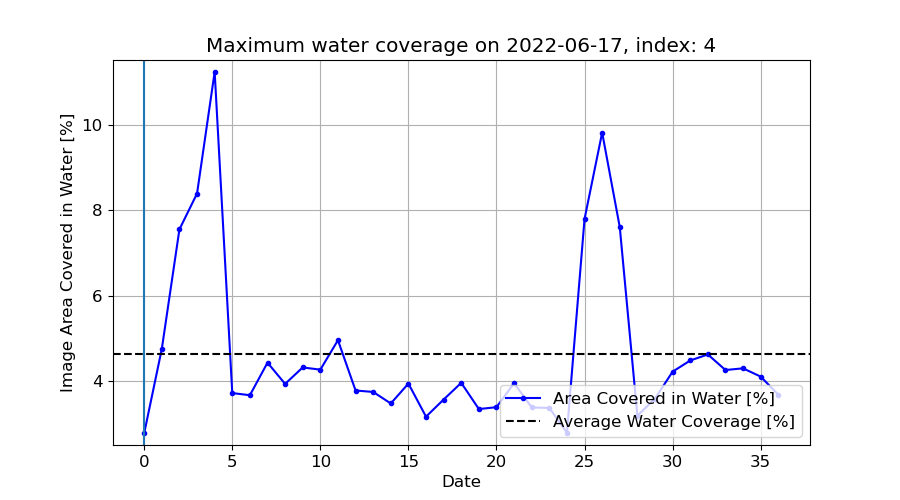

In [22]:
# List of available dataset
list_types = ['SAR', 'Water_Masks']
# List of available polarizations
list_polarization = ['VV', 'VH and VV'] #['VH', 'VH and VV', 'VV']

# Create the folder for the figures
pathfig = Path(fc.selected)/'Figures'
pathfig.mkdir(exist_ok=True)
ptf = Path(fc.selected)/'Figures/discharge'
ptf.mkdir(exist_ok=True)
ptf = Path(fc.selected)/'Figures/tp'
ptf.mkdir(exist_ok=True)

# Create vz, the dictionnary to hold our many variables
vz = {
    key1: {
        key2: {
            sub_key: [] for sub_key in [
                'Reof', 'Training_Data', 'Filetype', 'Polarization',
                'Coeffs', 'Modes', 'Models', 'Score', 'RMSE', 'Reof_forecast', 'Input_Images',
                'Reof_hindcast', 'Hindcast', 'Forecast', 'Best_Index', 'Difference',
                'Water_Hindcast', 'Water_Forecast'
            ]
        }
        for key2 in ['Polynomial', 'Neural']
    }
    for key1 in ['Q', 'ERA']
}



# Load the time template, every file combination has the same
tiff_dir = Path(fc.selected)/'RTC_GAMMA'
tiffs = list(tiff_dir.glob(f'*VV.tif*'))

times = get_dates(tiff_dir, '*VV')
times.sort()
times = pd.DatetimeIndex(times)
times.name = "time"

# Create a figure showing the average water extent throughout the timeseries to identify when floods occured
pathfig = Path(fc.selected)/'Figures'

floodpercent = np.load(pathfig/"flood_percentage.npy")
time_index = np.load(pathfig/"time_index.npy")
time_index = pd.DatetimeIndex(time_index)
plt.rcParams.update({'font.size': 12})

import matplotlib.dates as mdates
fig, ax = plt.subplots(figsize=(9,5))

ax.plot(np.arange(len(np.unique(time_index))), floodpercent, color='b', marker='o', markersize=3, label='Area Covered in Water [%]')
# Get the positions of the major tick locators on the x-axis
ax.set_ylim([np.min(floodpercent)-np.min(floodpercent)*0.1, np.max(floodpercent)+np.min(floodpercent)*0.1])
ax.set_xlabel('Date')


ax.axhline(y=np.mean(floodpercent), color='k', linestyle='--', label='Average Water Coverage [%]')
ax.set_ylabel('Image Area Covered in Water [%]')
# MODIFIED - start
# Description of modification - Knicely added "[0,0]," to ax.plot command to have vertical line at start (i.e., I set the x coordinates). 
# Note - this plot command seems extraneous. Why do we need a vertical line at the start of the data? 
ax.plot([0,0],[np.min(floodpercent)-np.min(floodpercent)*0.1, np.max(floodpercent)+np.min(floodpercent)*0.1])
# MODIFIED - end
ax.grid()
figname = ('ThresholdAndAreaTS.png')
ax.legend(loc='lower right')

# Set the x-axis tick positions
x_positions = np.arange(len(np.unique(time_index)))
major_tick_positions = ax.get_xticks()
dates_string = [None]
for i in range(1, len(major_tick_positions)-2):
    dates_string.append(str(time_index[int(major_tick_positions[i])])[:7])
dates_string.append(None)
dates_string.append(None)
'''
# Annotate the plot with the text from dates_string
for i, date_str in zip(x_positions, dates_string):
    ax.annotate(date_str, xy=(i, 1.01), xycoords='data', ha='right', va='bottom')
'''

plt.title(f"Maximum water coverage on {time_index[np.argmax(floodpercent)].strftime('%Y-%m-%d')}, index: {np.argmax(floodpercent)}")


# KNICELY - modification that will probably fail horribly. 
# plt.figure(fig) # this causes the figure to remain, but doesn't keep it interactive, and ends up doubling the figures. 



***
The above figure is not retained after reopening OSL. 
***

**Choose the time window for the forecast**

The index of the event you want to test.

**IMPORTANT:** if using the indices, choose -1 before your index of interest.

Example: the maximum water coverage occurs at index 50. Then I need to set sdaye = 49, edate = 50 so I can test the forecast for the date of the maximum water coverage.

In [23]:
import re

print("Choose a starting index and an end index (example: 10,11).")

while True:
    indices = input().replace(" ","") 
    inds = indices.split(',')
    start_ind = int(inds[0])
    stop_ind = int(inds[1])
    print(f"the dates you selected are {str(time_index[start_ind])[:10]} to {str(time_index[stop_ind])[:10]}")
    
    if (times[stop_ind]-times[start_ind]).days != 12:
        print(f"Your forecast is {(times[stop_ind]-times[start_ind]).days} days long, choose other indices. (most of the indices have 12 days intervals, try until it works)")
        continue
        
    # Description - Although no one should select an index of 1, this makes sure no one does. 
    if start_ind == 1:
        print(f"The starting index must be greater than 1.")
        continue

    # Validate the input format using a regular expression
    if not re.match(r'^\d+,\d+$', indices):
        print(indices)
        indices
        print("Please choose an appropriate input. It needs to be a number, a comma, and a number. No blank space.")
        continue
    
    break

# KNICELY - western - used 24 and 25. 
#           eastern - would be best ot use 25 and 26 since that actually has flooding and change, BUT I NEED TO MOSAICK, so use same dates. 

Choose a starting index and an end index (example: 10,11).


 24, 25


the dates you selected are 2023-04-01 to 2023-04-13


**Choose the polynomial metric ranking**

Choices:
- ('rmse','min')
- ('r2','max')
- ('r','max')

In [24]:
# Choose your metric ranking
metricranking = ('rmse','min')

### **Load the input variables**

This part of the script is where we load the input variables. If you want to add variables, make sure they are in the dataarray format (usually from .nc files).

They should have 1 value per day so they can be used by the functions we have.
If you want to add a variable, use the "mz" variable list. 

For example: I want to add another precipitation model. I will modify the code as follows:

In [25]:
### --- Example "mz" modification:
#mz = {
#    'Q': {
#        'Total': None,
#        'Selected': None,
#        'Forecast':None
#    },
#    'ERA': {
#        'Total': None,
#        'Selected': None,
#        'Forecast':None
#    },
#    'New_Model': {
#        'Total': None,
#        'Selected': None,
#        'Forecast':None
#    },   
#}




###### ------ LOAD THE INPUT VARIABLES ------ ######


#   ---   Discharge from GEOGLOWS   ---   #


# Convert 'times' to a dataarray to use with match_dates()
time_dataarray = xr.DataArray(np.array(times), dims='time', coords={'time': np.array(times)})

# Create MATCH, the list gathering the discharge and precipitations
mz = {
    'Q': {
        'Total': None,
        'Selected': None,
        'Forecast':None
    },
    'ERA': {
        'Total': None,
        'Selected': None,
        'Forecast':None
    }
}


# Load in memory the discharge  dataset (will be the same everytime)
lon,lat = get_centerpoint_coordinates(tiffs[0])
mz['Q']['Total'] = fierpy.get_streamflow(lat,lon)

# Check that we are not inputing a tuple
if type(mz['Q']['Total']) == tuple:
    mz['Q']['Total'] = mz['Q']['Total'][0]

mz['Q']['Selected'] = fierpy.match_dates(mz['Q']['Total'], time_dataarray[:start_ind])


#   ---   Precipitation from ERA5   ---   #


# First we need to get the coordinates of our AOI in order to crop the ERA5 input to our AOI

# Get the projection of the AOI
info = gdal.Info(str(tiffs[0]), format='json')
info = info['coordinateSystem']['wkt']
utm = info.split('ID')[-1].split(',')[1][0:-2]


# Get the coordinates of the AOI
geotiff_path = str(tiffs[0])
boundaries = get_coordinates_from_geotiff_bbox(geotiff_path)
for idx, corner in enumerate(boundaries, 1):
    lat, lon = corner
    print(f"Sanity Check: the coordinates of your AOI are: Corner {idx}: Latitude: {lat}, Longitude: {lon}")
    
# Then we can open out netcdf file

# Open Dataarray
era_ds = xr.open_dataarray(f"{Path(fc.selected).parent}/ERA5/era5_data.nc")

# Get the closest lats and lons from the AOI's boundaries, otherwise slicing the dataset can return empty slices
latmin = era_ds['latitude'].values[np.argmin(np.abs(era_ds['latitude'].values - boundaries[0,0]))]
latmax = era_ds['latitude'].values[np.argmin(np.abs(era_ds['latitude'].values - boundaries[1,0]))]
lonmin = era_ds['longitude'].values[np.argmin(np.abs(era_ds['longitude'].values - boundaries[0,1]))]
lonmax = era_ds['longitude'].values[np.argmin(np.abs(era_ds['longitude'].values - boundaries[1,1]))]

# Loading the precipitation and just grabbing the value at the same day at we have a SAR image acquisition is wrong.
# We try to alleviate that by summing the daily precipitation in between each SAR image, and adjusting that value based on the water extent trend.
# If the water extent between two images is going down, the total precipitation between two images is its sum multiplied by the coefficient of the
# slope between the two values of flooded area for the image at the time of the SAR acquisition.
# For example: if the flooded area percentage is 5 on the 01/01, and 2.5 on the 01/05, then the coefficient will be 0.5.


# Load in memory the precipitation dataset, fitted to the AOI, as a dataarray so it can use the match_dates function
era_ds = era_ds.sel(longitude = slice(lonmin, lonmax), latitude = slice(latmax, latmin))

# Convert to dataarray (sometimes ERA5 will give 2 levels of precipitation: ground and 5m altitude. We automatically take ground level.
if len(era_ds.shape) == 3:
    era_ds = np.sum(np.sum(era_ds, axis = 2), axis = 1)
else:
    era_ds = np.sum(np.sum(era_ds[:,0,:,:], axis = 2), axis = 1)

# Select the indices of era that intersect the input images
inds_match = era_ds.time.searchsorted(time_dataarray[:start_ind].time)

# Calculate the interval of days between each SAR acquisition
days_interval = inds_match[1:] - inds_match[:-1]

# There sometimes are gaps in SAR acquisitions of multiple months. Because precipitations are sums, we need to correct that to avoid having one day with meters of cumulated rainfall.
# In vast majority, repeat time of SAR acquisitions is 12 days. But we can directly calculate the median of our intervals and then divide our intervals by this median.
# This will give us a correction factor for the cumulated precipitations.
interval_correction = days_interval / 12

# Prepare the cumulative sums array 
cumulative_sum = np.zeros(len(inds_match))

# Calculate its first value by summing all the values before our first date, in the appropriate days interval
cumulative_sum[0] = np.sum(era_ds.isel(time=slice(inds_match[0]-int(np.median(days_interval)), inds_match[0])).values)

# Calculate the corrected precipitations by summing them between each acquisition, correct them with the sloop of flood maps and the amount of days in the interval
for i in range(1, len(inds_match)):
    # Apply a runoff based on the values of flood percentage of the images. If the trend is decreasing flood percentage, precipitation values decrease. If not, they stay the same
    if (floodpercent[i] / floodpercent[i-1]) > 1:
        runoff = 1
    else:
        runoff = floodpercent[i] / floodpercent[i-1]
    cumulative_sum[i] = (np.sum(era_ds.isel(time=slice(inds_match[i]-days_interval[i-1], inds_match[i])).values)*runoff) / interval_correction[i-1]

# Create a new DataArray with cumulative sum values
era_sel = xr.DataArray(cumulative_sum, dims=('time'), coords={'time': time_dataarray[:start_ind].time})



#   ---   Fill the Variables list   --- #
mz['ERA']['Total'] = era_ds
mz['ERA']['Selected'] = era_sel



Sanity Check: the coordinates of your AOI are: Corner 1: Latitude: 25.182345197530935, Longitude: 81.42200402830679
Sanity Check: the coordinates of your AOI are: Corner 2: Latitude: 25.631194634261625, Longitude: 82.20701514417021


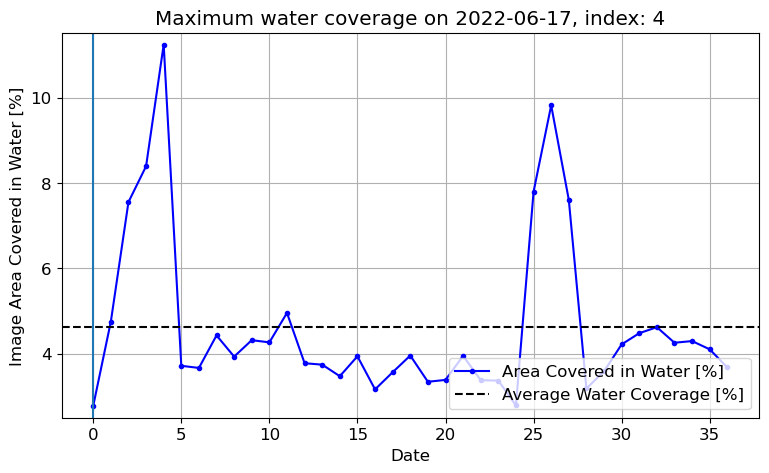

In [27]:
plt.figure(fig)

##### **Run this cell twice to ensure the transition from interactive plots to inline plots**

Note from Knicely: this doesn't quite work. If you do it MORE than twice, it completely breaks. What is this supposed to do? I'm told it was here to prevent images from disappearing, but that doesn't seem to be a problem. 

In [28]:
# # ORIGINAL SET UP
# from importlib import reload
# reload(plt)
# %matplotlib inline
# reload(plt)
# %matplotlib inline
# plt.figure()
# plt.close()
# plt.figure()
# plt.close()

### **Looper**


In [29]:
vz

{'Q': {'Polynomial': {'Reof': [],
   'Training_Data': [],
   'Filetype': [],
   'Polarization': [],
   'Coeffs': [],
   'Modes': [],
   'Models': [],
   'Score': [],
   'RMSE': [],
   'Reof_forecast': [],
   'Input_Images': [],
   'Reof_hindcast': [],
   'Hindcast': [],
   'Forecast': [],
   'Best_Index': [],
   'Difference': [],
   'Water_Hindcast': [],
   'Water_Forecast': []},
  'Neural': {'Reof': [],
   'Training_Data': [],
   'Filetype': [],
   'Polarization': [],
   'Coeffs': [],
   'Modes': [],
   'Models': [],
   'Score': [],
   'RMSE': [],
   'Reof_forecast': [],
   'Input_Images': [],
   'Reof_hindcast': [],
   'Hindcast': [],
   'Forecast': [],
   'Best_Index': [],
   'Difference': [],
   'Water_Hindcast': [],
   'Water_Forecast': []}},
 'ERA': {'Polynomial': {'Reof': [],
   'Training_Data': [],
   'Filetype': [],
   'Polarization': [],
   'Coeffs': [],
   'Modes': [],
   'Models': [],
   'Score': [],
   'RMSE': [],
   'Reof_forecast': [],
   'Input_Images': [],
   'Reof_hin

In [30]:
mz

{'Q': {'Total': <xarray.DataArray 'discharge' (time: 16252)>
  array([ 0.        ,  0.40382773,  0.4693316 , ...,  0.09900803,
          2.1153436 , 17.222326  ])
  Coordinates:
    * time     (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2023-06-30,
  'Selected': <xarray.DataArray 'discharge' (time: 24)>
  array([0.17704697, 0.14124198, 0.10257287, 0.0738449 , 0.08002056,
         0.09937365, 0.48801458, 0.08611814, 0.13594301, 5.6987987 ,
         0.76519275, 1.1291798 , 1.1125364 , 0.98646265, 0.837478  ,
         0.71066415, 0.61023605, 0.483876  , 0.4455029 , 0.40926173,
         0.3712948 , 0.32788798, 0.28833586, 0.28533107])
  Coordinates:
    * time     (time) datetime64[ns] 2022-04-06 2022-04-18 ... 2023-03-20,
  'Forecast': None},
 'ERA': {'Total': <xarray.DataArray 'tp' (time: 650)>
  array([ 7.73929060e-07,  3.90037894e-06, -2.68220901e-07, -2.68220901e-07,
          7.47771002e-04,  1.34814769e-01,  1.03887379e-01,  3.71772274e-02,
          9.06968564e-02,  6.28039986e

***
# Execute the REOF.

This is the most RAM intensive part of the process and is where the notebook is most likely to fail. Code has been (*will be*) added to approximate the total needed RAM and warn the user if this is likely to be exceeded. 



In [ ]:
# Store REOFs and Datasets
reofs = []
datasets = []

start = time.time()

# get current RAM usage
# tracemalloc.start()

# Iterate through every dataset type and polarization to compute the fits with the discharge
c = 1
for filetype, polarization in zip(list_types, list_polarization):
    looper(reofs, datasets, mz, filetype,
                                        polarization,
                                        start_ind,
                                        metricranking,
                                        vz,
                                        fitting=True,
                                        plotting = True
                                        )
    print(f"{c}/2 | Finished computing {filetype} {polarization}")
    c += 1 # only used to display messages. 
    
        
end = time.time()

print(f"\nRuntime for this cell was: {(end-start)/60.0} minutes")

# print out info about RAM usage. This is to develop an empirical estimation of RAM usage. 
# current, peak = tracemalloc.get_traced_memory()
# print(f'current, peak memory: {current/(1024.0**3)}, {peak/(1024.0**3)} [GB]}')
# tracemalloc.stop()

In REOF loop
RAM Used [GB]: 4.616756439208984
RAM Total [GB]: 123.67463302612305

Starting REOF
Memory before freof call: 0.0, 0.0
Input data stats
Number of Frames: 25
Size (shape) of Frames: (1641, 2622)
current, peak [GB] = 0.24083441589027643, 14.570716219954193
Finished REOF
In looper - before find_best_fit_nn call
RAM Used [GB]: 5.893436431884766
RAM Total [GB]: 123.67463302612305
Computing mode 0
Computing mode 1
Computing mode 2
Computing mode 3
Computing mode 4
Computing mode 5
Computing mode 6
Computing mode 7
Computing mode 8
Computing mode 9
Computing mode 10
Computing mode 11
Computing mode 12
Computing mode 13
In looper - after find_best_fit_nn call
RAM Used [GB]: 5.964344024658203
RAM Total [GB]: 123.67463302612305
In looper - before find_best_fit_nn call
RAM Used [GB]: 5.952278137207031
RAM Total [GB]: 123.67463302612305
Computing mode 0
Computing mode 1
Computing mode 2
Computing mode 3
Computing mode 4
Computing mode 5
Computing mode 6
Computing mode 7
Computing mode 

## **Visualize the fits**

**Select the best mode and associated coefficients based on the ranking score**

In [ ]:
vz2 = vz
# what is this supposed to do? Create a duplicate? Because it doesn't; this assigns a reference to 'vz' from 'vz2'. 
# Anything that happens to 'vz' will happen to 'vz2' and vice versa. 

In [ ]:
for var in ['Q','ERA']:
    
    # Depending on the metric, best score might be min or max value in the score list
    if metricranking[1] == 'min':
        vz[var]['Polynomial']['Best_Index'] = min(range(len(vz[var]['Polynomial']['Score'])), key=lambda i: abs(vz[var]['Polynomial']['Score'][i]))
    else:
        vz[var]['Polynomial']['Best_Index'] = max(range(len(vz[var]['Polynomial']['Score'])), key=lambda i: abs(vz[var]['Polynomial']['Score'][i]))
    # Determine the filetype and polarization of best input
    vz[var]['Polynomial']['Filetype'] = list_types[vz[var]['Polynomial']['Best_Index']]
    vz[var]['Polynomial']['Polarization'] = list_polarization[vz[var]['Polynomial']['Best_Index']]
        
    # Do the same for the neural network
    vz[var]['Neural']['Best_Index']  = vz[var]['Neural']['RMSE'].index(min(vz[var]['Neural']['RMSE']))
    vz[var]['Neural']['Filetype'] = list_types[vz[var]['Neural']['Best_Index']]
    vz[var]['Neural']['Polarization'] = list_polarization[vz[var]['Neural']['Best_Index']]
    
    # Replace the coeffs, modes and models by their best iteration
    vz[var]['Polynomial']['Coeffs'] = np.array(vz[var]['Polynomial']['Coeffs'][vz[var]['Polynomial']['Best_Index']])
    vz[var]['Polynomial']['Modes'] = vz[var]['Polynomial']['Modes'][vz[var]['Polynomial']['Best_Index']]
    vz[var]['Neural']['Models'] = vz[var]['Neural']['Models'][vz[var]['Neural']['Best_Index']]
    
    # Attribute to each variable and method its optimal reof and dataset
    if vz[var]['Polynomial']['Filetype'] == "SAR":
        vz[var]['Polynomial']['Reof'], vz[var]['Polynomial']['Training_Data'] = reofs[0], datasets[0]
    else: # If not SAR, Water_Masks is the best dataset along with its REOF
        vz[var]['Polynomial']['Reof'], vz[var]['Polynomial']['Training_Data'] = reofs[1], datasets[1]
                   
    # Do the same for Neural method
    if vz[var]['Neural']['Filetype'] == "SAR":
        vz[var]['Neural']['Reof'], vz[var]['Neural']['Training_Data'] = reofs[0], datasets[0]
    else:
        vz[var]['Neural']['Reof'], vz[var]['Neural']['Training_Data'] = reofs[1], datasets[1]
    
    # Fill the hindcasts               
    vz[var]['Polynomial']['Hindcast'] = vz[var]['Polynomial']['Training_Data'][start_ind:stop_ind+1]
    vz[var]['Neural']['Hindcast'] = vz[var]['Neural']['Training_Data'][start_ind:stop_ind+1]
                   


**Prepare the datasets for the fit**

In [ ]:
# We fill in the NaNs to avoid breaking the fit
for var, reg in zip(['Q','ERA'],['Polynomial','Neural']):
    vz[var][reg]['Reof'].fillna(0)

In [ ]:
from importlib import reload
reload(plt)
%matplotlib inline
fig, ax = plt.subplots(figsize=(15,5), ncols=2)

xlabels = ['Discharge [$m^{3}.s^{-1}$]', 'Precipitations [$m.d^{-1}$]']
for var, i in zip(['Q','ERA'],range(2)):
    vals = vz[var]['Polynomial']
    x = np.linspace(0, mz[var]['Selected'].max(),100)
    f = np.poly1d(np.squeeze(vals['Coeffs']))
    ax[i].plot(mz[var]['Selected'],vals['Reof'].temporal_modes[:,vals['Modes']], 'o', label=f"{metricranking[0]} = {np.round(vals['Score'][vals['Best_Index']],5)}")
    ax[i].legend()
    ax[i].set_xlabel(xlabels[i])
    ax[i].set_ylabel('Time series amplitude')
    ax[i].plot(x,f(x))
    ax[i].set_title(f"Fit for mode {vals['Modes']}, poly degree {len(vals['Coeffs'])-1}, {vals['Filetype']}_{vals['Polarization']}")            
plt.savefig(pathfig/f"Polynomial_Fit_{times[0].strftime('%Y-%m-%d')}_{times[start_ind].strftime('%Y-%m-%d')}.png")

# KNICELY - there are 5 graphs below. The titles are as given: 
#     Maximum water coverage on 2022-06-17, index: 4
#     90% of the variance is explained by the first 15 modes
#     90% of the variance is explained by the first 10 modes
#     [2 side by side]: On left - Fit for mode 9, poly degree 1, Water_Masks_VH and VV; On right - Fit for mode 8, poly degree 1, Water_Masks_VH and VV
#     ALL PLOTS WERE RETAINED. This code seems to make an explicit plot call ('ax[i].plot(stuff)' and not 'ax[i].plot()')

In [ ]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

row_titles = [f"Discharge | {vz['Q']['Neural']['Filetype']}_{vz['Q']['Neural']['Polarization']}, RMSE: {min(vz['Q']['Neural']['RMSE']):.3f}",
              f"Precipitation | {vz['ERA']['Neural']['Filetype']}_{vz['ERA']['Neural']['Polarization']}, RMSE: {min(vz['ERA']['Neural']['RMSE']):.3f}"]


width_per_subplot = 5  # Desired width (in inches) for each subplot
num_columns = len(vz[var]['Polynomial']['Reof'].mode.values)
fig_width = num_columns * width_per_subplot

fig = plt.figure(constrained_layout=True, figsize=(15, 10))

labels = ['Discharge','Precipitation']
# Create 3x1 subfigs
subfigs = fig.subfigures(nrows=2, ncols=1)

for var, i in zip(['Q','ERA'],range(2)):
    subfigs[i].suptitle(f'{row_titles[i]}')

    # Create 1x3 subplots per subfig
    axs = subfigs[i].subplots(nrows=1, ncols=4)
    axs[i].set_ylabel('Normalized Values', color='black')
    axs[i].yaxis.set_label_coords(-0.2, 0.5)
    
    for col, ax in enumerate(axs):
        reof_norm = normalize(vz[var]['Polynomial']['Reof'].temporal_modes[:, col])
        vari = normalize(mz[var]['Selected'])
        # Plotting the data with modified labels and line styles
        ax.plot(times[:start_ind], (reof_norm - np.min(reof_norm)) / (np.max(reof_norm) - np.min(reof_norm)),
                        label='RTPC', linestyle='-', linewidth=2, color='black')  # RTPC - Red solid line
        ax.plot(times[:start_ind], (vari - np.min(vari)) / (np.max(vari) - np.min(vari)),
                        label=labels[i], linestyle='--', linewidth=2, dashes=(5, 2), color='blue')  # Discharge - Dashed line
        ax.set_xlabel('Times')  # X-axis label
        ax.set_ylabel('Normalized Values')  # Y-axis label
        corr, _ = pearsonr(reof_norm, vari)
        ax.set_title(f'Mode {col+1} (Corr: {corr:.3f})', fontsize=20)  # Subplot title with correlation
        ax.legend(fontsize=17)  # Show legend
        ax.tick_params(axis='x', rotation=45)  # Rotate x-axis tick labels by 45 degrees


#plt.tight_layout()  # Adjust the layout spacing
plt.show()  # Display the plot
plt.savefig(pathfig/f"Variables_Modes_Correlations_{times[0].strftime('%Y-%m-%d')}_{times[start_ind].strftime('%Y-%m-%d')}.png")

# KNICELY - there is 1 figure made of 8 panels, 4 in the top row, 4 in the bottom. 
# FIGURE WITH 8 PANELS RETAINED!!! Explicit plot call again. 

<hr>

## **Forecast**

#### **Calculate the forecast of flooding based on the relationship between discharge and the main modes of our dataset**

**Calculate the amount of days between sdate and edate**

In [ ]:
# Amount of days for the forecast
nb_days_forecast = (times[stop_ind] - times[start_ind]).days

**Generate the forecast based on the best fit coefficients**

In [ ]:
# Generate new dates array nb_days_forecast days into the future and save them as a dataset
forecast_dates = xr.Dataset.from_dataframe(
                    pd.DataFrame(
                        {'time': datasets[0][start_ind].time.values +
                         np.arange(1, nb_days_forecast+1, dtype='timedelta64[D]')}
                    )
                    )

for var in ['Q','ERA']:
    mz[var]['Forecast'] = fierpy.match_dates(mz[var]['Total'],forecast_dates)
    
    if var == 'Q':
        namefig = 'discharge'
    else:
        namefig = 'tp'
    

    # Use the previously found relationships and functions to generate RTC/mask forecast
    vz[var]['Polynomial']['Forecast'] = fierpy.synthesize(vz[var]['Polynomial']['Reof'],
                                                          mz[var]['Forecast'],
                                                          np.poly1d(vz[var]['Polynomial']['Coeffs']),
                                                          vz[var]['Polynomial']['Modes'])

    vz[var]['Neural']['Forecast'] = synthesize_neural(mz[var]['Forecast'],
                                                      vz[var]['Neural']['Models'],
                                                      vz[var]['Neural']['Reof'],
                                                      namefig)


In [ ]:
class NoHANDLayerException(Exception):
    """
    Raised when expecting path to HAND layer but none found
    """
    pass

#load HAND and derive HAND-EM
Hthresh = 15

path_HAND = Path(fc.selected)/'DEM/'
HAND_file = list(path_HAND.glob(f'*hand*'))[0]

print(f"Selected HAND: {HAND_file}")
try:
    HAND_gT = gdal_get_geotransform(HAND_file)
except AttributeError:
    raise NoHANDLayerException("You must select a HAND layer in the previous code cell")
info = (gdal.Info(str(HAND_file), format='json'))
info = info['coordinateSystem']['wkt']
Hzone = info.split('ID')[-1].split(',')[1][0:-2]
Hproj_type = info.split('ID')[-1].split('"')[1]
HAND=gdal_read(HAND_file)
hand = np.nan_to_num(HAND)

# Create Binary HAND-EM
Hmask = hand < Hthresh
handem = np.zeros_like(hand)
sel = np.ones_like(hand)
handem[Hmask] = sel[Hmask]


# Prepare the arrays to host the scores results
CSI=np.zeros((4))
Overall = np.zeros((4))
Precision = np.zeros((4))
Recall = np.zeros((4))

# Calculate the scores
i = 0
for var in ['Q','ERA']:
    for reg in ['Polynomial','Neural']:
        Overall[i], CSI[i], Precision[i], Recall[i], vz[var][reg]['Water_Forecast'], vz[var][reg]['Water_Hindcast'] = Z_Score_Iterative(vz, var, reg, handem)
        print(f"#### ---- Finished computing {var} {reg} ---- ####")
        i += 1

# Define the row and column labels
row_labels = ['Discharge', 'Precipitation']
column_labels = ['Polynomial', 'Neural']

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the matrix using imshow
im = ax.imshow(np.array([precision-recall for precision, recall in zip(Precision, Recall)]).reshape((2,2)), cmap='RdYlGn')

# Add ticks and labels to the x-axis and y-axis
ax.set_xticks(np.arange(len(column_labels)))
ax.set_yticks(np.arange(len(row_labels)))
ax.set_xticklabels(column_labels)
ax.set_yticklabels(row_labels)

p = 0
# Loop over the data to add text annotations in each cell
for i in range(len(row_labels)):
    for j in range(len(column_labels)):
        text = ax.text(j, i, f"CSI: {CSI[p]:.2f}\nTot: {Overall[p]:.2f}\nPrecision: {Precision[p]:.2f}\nRecall: {Recall[p]:.2f}", ha='center', va='center', color='white')
        p += 1

# Set the title
ax.set_title("Forecast Scores")

# Add a colorbar
cbar = ax.figure.colorbar(im, label='Precision-Recall Score')

# Show the plot
plt.show()

fig.savefig(pathfig/f"Scores_{times[0].strftime('%Y-%m-%d')}_{times[start_ind].strftime('%Y-%m-%d')}.png")

# KNICELY - there is a plot of the forecast scores at the bottom of this (uner all the Mask #/12 text)
# PLOT OF FORECAST SCORES RETAINED!!!

### **Plot the forecasts and their associated real data to compare spatial correspondance**
*The colorbar is adjusted to the values of each normalized dataset. We use as colorbar boundaries:
$\mu(\text{dataset})\pm\sigma(\text{dataset})$*

In [ ]:
# Automatically set the size of the plot

names = ['Discharge','','Precipitation']

for reg, r in zip(['Polynomial', 'Neural'], range(2)):
    
    ncols = 1  # Number of columns in your subplots
    nrows = 4
    width_ratios = [1] * ncols  # Equal width for subplots, and additional space for colorbar
    width_ratios[-1] += 0.075
    height_ratios = [1] * nrows

    width_per_subplot = 5  # Desired width (in inches) for each subplot
    fig_width = num_columns * width_per_subplot

    # Start Figure
    fig, ax = plt.subplots(figsize=(20, 20), nrows = 4, ncols = 1, gridspec_kw={'width_ratios': width_ratios, 'height_ratios': height_ratios})
    
    # Create title
    #fig.suptitle(f"Q: {vz['Q'][reg]['Filetype']} {vz['Q'][reg]['Polarization']}, mode {vz['Q'][reg]['Modes']}, poly deg {len(vz['Q'][reg]['Coeffs'])-1} | Prec: {vz['ERA'][reg]['Filetype']} {vz['ERA'][reg]['Polarization']}, mode {vz['ERA'][reg]['Modes']}, poly deg{len(vz['ERA'][reg]['Coeffs'])-1}", fontsize = 18)


    for var, j in zip(['Q', 'ERA'], [0,2]):
        forecast = vz[var][reg]['Forecast'][-1]
        hindcast = vz[var][reg]['Hindcast'][0]


        # Loop to plot the data. We use the forecast and their associated real data, normalized
        # The colorbar is varying from -std+mean to std+mean
           

        plt.figure()
        forecast = np.ma.masked_where(forecast == 0, forecast)
        hindcast = np.ma.masked_where(hindcast == 0, hindcast)

        im0 = ax[j].imshow(hindcast, cmap='magma', interpolation="none", vmin=0, vmax=1.2)
        ax[0].set_title(f"{reg} {str(vz[var][reg]['Forecast'][i].time.values)[0:10]}, d{nb_days_forecast}", fontsize = 17)
        im1 = ax[j+1].imshow(forecast, cmap='magma', interpolation="none", vmin=0, vmax=1.2)

        ax[j].set_xticks([])
        ax[j].set_yticks([])
        ax[j+1].set_xticks([])
        ax[j+1].set_yticks([])

        ax[j].set_ylabel(f"Hindcast {vz[var][reg]['Filetype']} {vz[var][reg]['Polarization']}", fontsize = 15)
        ax[j+1].set_ylabel(f"Forecast {vz[var][reg]['Filetype']} {vz[var][reg]['Polarization']}", fontsize = 15)
                
        



    # rearange the axes for no overlap
    fig.tight_layout()

    # Plot line in the middle
    line = plt.Line2D([0,1],[0.495,0.495], transform=fig.transFigure, color="red")
    # Create the first title for the first two rows
    title1 = fig.text(0.1, 0.75, 'Discharge', va='center', ha='center', rotation='vertical', color='red', fontsize = 20)

    # Create the second title for the last two rows
    title2 = fig.text(0.1, 0.25, 'Precipitations', va='center', ha='center', rotation='vertical', color='red', fontsize = 20)

    fig.add_artist(line)


    fig.savefig(pathfig/f"Forecast_Hindcast_{reg}_{times[0].strftime('%Y-%m-%d')}_{times[start_ind].strftime('%Y-%m-%d')}.png")
    
# KNICELY - 2 sets of 4 figures. 
# 4 of the figures are hindcast water flood; white
# TWO SETS OF FOUR FIGURES RETAINED!!! Again, explicit plot call. 

**Compare the water masks from the Z-score**

In [ ]:
# Automatically set the size of the plot
for reg, r in zip(['Polynomial', 'Neural'], range(2)):
    
    ncols = 1  # Number of columns in your subplots
    nrows = 4
    width_ratios = [1] * ncols  # Equal width for subplots, and additional space for colorbar
    width_ratios[-1] += 0.075
    height_ratios = [1] * nrows

    width_per_subplot = 5  # Desired width (in inches) for each subplot
    fig_width = num_columns * width_per_subplot

    # Start Figure
    fig, ax = plt.subplots(figsize=(20, 20), nrows = 4, ncols = 1, gridspec_kw={'width_ratios': width_ratios, 'height_ratios': height_ratios})
    
    # Create title
    #fig.suptitle(f"Q: {vz['Q'][reg]['Filetype']} {vz['Q'][reg]['Polarization']}, mode {vz['Q'][reg]['Modes']}, poly deg {len(vz['Q'][reg]['Coeffs'])-1} | Prec: {vz['ERA'][reg]['Filetype']} {vz['ERA'][reg]['Polarization']}, mode {vz['ERA'][reg]['Modes']}, poly deg{len(vz['ERA'][reg]['Coeffs'])-1}", fontsize = 18)


    for var, j in zip(['Q', 'ERA'], [0,2]):
        forecast = vz[var][reg]['Water_Forecast'][-1]
        hindcast = vz[var][reg]['Water_Hindcast']


        # Loop to plot the data. We use the forecast and their associated real data, normalized
        # The colorbar is varying from -std+mean to std+mean
           

        plt.figure()
        forecast = np.ma.masked_where(forecast == 0, forecast)
        hindcast = np.ma.masked_where(hindcast == 0, hindcast)

        im0 = ax[j].imshow(hindcast, cmap='Blues', interpolation="none", vmin=0, vmax=1.2)
        ax[0].set_title(f"{reg} {str(vz[var][reg]['Forecast'][i].time.values)[0:10]}, d{nb_days_forecast}", fontsize = 17)
        im1 = ax[j+1].imshow(forecast, cmap='Blues', interpolation="none", vmin=0, vmax=1.2)

        ax[j].set_xticks([])
        ax[j].set_yticks([])
        ax[j+1].set_xticks([])
        ax[j+1].set_yticks([])

        ax[j].set_ylabel(f"Water Hindcast {vz[var][reg]['Filetype']} {vz[var][reg]['Polarization']}", fontsize = 15)
        ax[j+1].set_ylabel(f"Water Forecast {vz[var][reg]['Filetype']} {vz[var][reg]['Polarization']}", fontsize = 15)


    # rearange the axes for no overlap
    fig.tight_layout()

    # Plot line in the middle
    line = plt.Line2D([0,1],[0.495,0.495], transform=fig.transFigure, color="red")
    # Create the first title for the first two rows
    title1 = fig.text(0.1, 0.75, 'Discharge', va='center', ha='center', rotation='vertical', color='red', fontsize = 20)

    # Create the second title for the last two rows
    title2 = fig.text(0.1, 0.25, 'Precipitations', va='center', ha='center', rotation='vertical', color='red', fontsize = 20)

    fig.add_artist(line)


    fig.savefig(pathfig/f"Water_Extent_{reg}_{times[0].strftime('%Y-%m-%d')}_{times[start_ind].strftime('%Y-%m-%d')}.png")
    


In [ ]:
# Add figure with runoff on top and water for each forecasted day
# Animation to show SLC input

for reg in ['Polynomial','Neural']:
    for var in ['Q','ERA']:
        fig = plt.figure(figsize=(15,15))
        gs = fig.add_gridspec(4, 4)
        ax1 = fig.add_subplot(gs[0, :])
        ax11 = ax1.twinx()

        q_min, q_max = np.where(mz['Q']['Total'].time == time_dataarray[start_ind].time)[0][0], np.where(mz['Q']['Total'].time == time_dataarray[stop_ind].time)[0][0]
        era_min, era_max = np.where(mz['ERA']['Total'].time == time_dataarray[start_ind].time)[0][0], np.where(mz['ERA']['Total'].time == time_dataarray[stop_ind].time)[0][0]

        days = [f"d{i}" for i in range(1,nb_days_forecast+1)]

        ax1.plot(days, mz['Q']['Total'][q_min:q_max])
        ax11.plot(days, mz['ERA']['Total'][era_min:era_max], color='red')
        ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
        ax1.set_xlabel('Days forecast')
        ax1.set_ylabel('Discharge [$m^{3}.s^{-1}$]')
        ax11.set_ylabel('Precipitation [$m.d^{-1}$]')
        plt.title(f"Forecast from {vz[var][reg]['Filetype']} {vz[var][reg]['Polarization']}")

        # Plot n images from vz['Q']['Polynomimal']['Water_Forecast']
        p = 0
        for i in range(1,4):
            for j in range(4):
                forecast = vz[var][reg]['Water_Forecast'][p]
                ax = fig.add_subplot(gs[i,j])  # Create subplots for each image
                ax.imshow(forecast, cmap='Blues', interpolation="none", vmin=0, vmax=1.2)
                ax.set_title(f'd{p+1}')
                ax.set_xticks([])  # Turn off xticks
                ax.set_yticks([])  # Turn off yticks
                ax.set_xlabel('')  # Turn off x-axis label
                ax.set_ylabel('')  # Turn off y-axis label
                p += 1

        fig.savefig(pathfig/f"Daily_WM_{reg}_{var}_{times[0].strftime('%Y-%m-%d')}_{times[start_ind].strftime('%Y-%m-%d')}.png")


## Plot the temporal modes, spatial modes, and an animation of the SLC SAR imagery

About the temporal modes:
* Have these color coded based on time of year: before and after monsoon season (~mid August)
* This has been set up as a slider widget so the user can go through each temporal mode. 

About the spatial modes: 
* This has been set up as a slider widget so the use can go through each spatial mode. 

About the SLC SAR imagery
* This is loaded as a slider widget. 

To Do
* Display widgets as a single subplot so the user can look at all of them simultaneously rather than going back and forth. 


In [ ]:
import datetime
# this date will be used to determine if a temporal mode point is from before or after the monsoon season. 
# Note: The year does not matter. 
monsoon_date = datetime.datetime(2020,8,15) # year, month, day; the year doesn't actually matter. 
monsoon_date

In [ ]:
# get whether a date is before or after the start of monsoon season. 
trueIfBefore = [False for i in range(0,start_ind)]

for i in range(0,start_ind):
    if (times[i].month, times[i].day) > (monsoon_date.month, monsoon_date.day): 
        trueIfBefore[i] = False
    else: 
        trueIfBefore[i] = True


Write the functions that will display the temporal modes, spatial modes, and the radar imagery. 

Source for the below slider method that worked: https://github.com/jupyter-widgets/ipywidgets/blob/main/docs/source/examples/Image%20Browser.ipynb

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from ipywidgets import interact
from ipywidgets import Play

In [ ]:
# create a function that allows the user to flip through all of the sar images. 
def browse_images(images_array,times):
    n = images_array.shape[0]
    vmin = np.nanpercentile(images_array,5)
    vmax = np.nanpercentile(images_array,95)
    def view_image(Radar_Image=0):
        # plt.figure(figsize=(8,6))
        
        plt.title(f'Slideshow test! image number: {Radar_Image} \nDate: {times[Radar_Image].date()}')
        plt.xlabel('Easting')
        plt.ylabel('Northing')
        
        plt.ylim(images_array.shape[1],0) # attempt to deal with spasm from creating each image; didn't work!
        
        plt.imshow(images_array[Radar_Image,:,:],vmin=vmin,vmax=vmax)
        plt.colorbar()
        
    interact(view_image, Radar_Image=(0,n-1))

In [ ]:
# create a function that allows the user to flip thorugh all of the spatial modes
def browse_spatialModes(spatialModes,clims=False):
    n = spatialModes.shape[-1]
    if clims:
        cb_min = np.amin(spatialModes)
        cb_max = np.amax(spatialModes)
    def view_image(spatialMode=0):
        # plt.figure(figsize=(8,6))
        
        plt.title(f'Slideshow test! Spatial Mode: {spatialMode}')
        plt.xlabel('Easting')
        plt.ylabel('Northing')
        
        plt.imshow(spatialModes.values[:,:,spatialMode])
        plt.colorbar()
        if clims:
            plt.clim(cb_min, cb_max)
        
    interact(view_image, spatialMode=(0,n-1))

In [ ]:
# create a function that allows the user to flip through all of the temporal modes
def browse_temporalModes(selected,coeffs,temporalModes,condits,ylims=False):
    n = temporalModes.shape[-1]
    
    x = np.linspace(0,selected.max(),100)
    f = np.poly1d(np.squeeze(coeffs))
    
    ymax = temporalModes.max()*1.1
    ymin = temporalModes.min()*1.1
    
    def view_temporalMode(temporalMode = 0):
        fig = plt.figure(figsize=(8,6))
        
        plt.title(f"Test of temporal modes slideshow\nMode: {temporalMode}")
        plt.ylabel('Time Series Amplitude')
        plt.xlabel('depends on which one you gave the function!')
        if selected.name == 'discharge':
            plt.xlabel('Discharge [$m^3$ / s]')
        else:
            plt.xlabel('Precipitation [INSERT UNITS]')
        
        if ylims:
            plt.ylim((ymin,ymax)) # this makes the graphs look like GARBAGE!!!
        
        # plot the data based on conditions
        # plot temporal modes before monsoon season
        plt.plot(selected[condits],temporalModes[condits,temporalMode],'o', color='green')
        plt.plot(selected[np.invert(condits)],temporalModes[np.invert(condits),temporalMode],'o', color='blue')
        
        # plot the polynomial fit
        plt.plot(x,f(x),color='orange')
        
    # run the widget
    interact(view_temporalMode,temporalMode=(0,n-1))

***
The below will display the temporal and spatial modes without scaling. This will cause each mode to have a different scale. This can be beneficial for viewing small details in each of modes. 

In [ ]:
browse_images(datasets[0],times)
browse_spatialModes(vz['Q']['Neural']['Reof'].spatial_modes,clims=False)
browse_temporalModes(mz['Q']['Selected'],vz['Q']['Polynomial']['Coeffs'],vz['Q']['Polynomial']['Reof'].temporal_modes,trueIfBefore,ylims=False)

***
The below will display the temporal and spatial modes all scaled to the greatest max/min extent. This is excellent for displaying the relative amount of "power" (this is the wrong word!) that each mode has. 

In [ ]:
browse_images(datasets[0],times)
browse_spatialModes(vz['Q']['Neural']['Reof'].spatial_modes,clims=True)
# look at the temporal modes with the ylims set
browse_temporalModes(mz['Q']['Selected'],vz['Q']['Polynomial']['Coeffs'],vz['Q']['Polynomial']['Reof'].temporal_modes,trueIfBefore,ylims=True)

***
Save figures of the spatial modes for later viewing. 

In [ ]:
# function to create and save spatial mode figures
from datetime import date
def spatialModeFigures(mainFolder,twoDarray,modeNumber,saveFig = True):
    fig = plt.figure(constrained_layout=True, figsize=(8, 6))
    labels = ['Easting','Northing']

    #modeNumber = 0
    font = {'size':20}

    plt.title((f"Spatial Mode: {modeNumber} \t Correlation: ???").expandtabs(),fontdict = font)
    plt.xlabel('Easting', fontdict = font)
    plt.ylabel('Northing', fontdict = font)
    plt.imshow(twoDarray[:,:])

    # add colorbar to show values
    cb_max = np.amax(twoDarray)
    cb_min = np.amin(twoDarray)
    plt.colorbar()
    plt.clim(cb_min,cb_max)

    saveloc = os.path.join(mainFolder,'Figures','spatialModes')
    Path(saveloc).mkdir(parents=True, exist_ok=True)

    if saveFig:
        fig_saveName = os.path.join(saveloc,f"spatialMode-{str(modeNumber+1)}_{str(date.today())}.png")
        fig.savefig(fig_saveName)
    return

In [ ]:
# Loop through all of the spatial modes and save the figures. 

for i in range(vz['Q']['Neural']['Reof'].spatial_modes.values.shape[-1]):
    spatialModeFigures(fc.selected,vz['Q']['Neural']['Reof'].spatial_modes.values[:,:,i],i,saveFig=True)

***
## Plot the discharge and precipitation zscores vs time

This will replicate the following image: 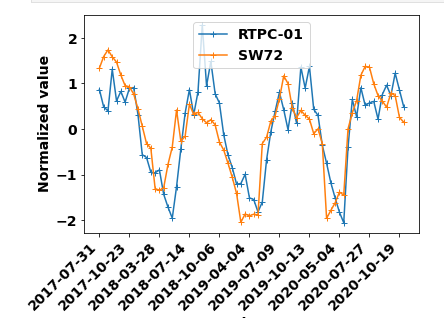

Zcore is z = (x-mu)/sigma, where x is a particular value, mu is the mean of all the values, and sigma is the standard deviation. It is a measure of how many standard deviations from the mean a particular value is. 

In this context, when the value gets low (negative), it's pointing out the dry season; when it gets high, it's pointing out the wet season. 


In [ ]:
import scipy as sci


def browse_Zscores(temporalModes, hydro):
    n = temporalModes.shape[-1]
    theTimes = hydro.time
    
    def view_Zscores(temporalMode = 0):
        fig = plt.figure()
        
        plt.title(f"Zscores - Temporal Mode & Discharge\nMode: {temporalMode}")
        plt.ylabel("Zscore [unitless]")
        plt.xlabel("Date [Year - Month]")
        
        hydro_zscores = sci.stats.zscore(mz['Q']['Selected'])
        plt.plot(theTimes.values, hydro_zscores, color = 'orange', marker = '+', label='GeoGlows Data')
        
        tpc_zscore = sci.stats.zscore(temporalModes.sel(mode=int(temporalMode)))
        plt.plot(theTimes.values, tpc_zscore, color = 'blue', marker = '*', label = 'Temporal Mode')
        
        plt.legend(loc='upper left')
        
        plt.xticks(rotation=45)
        plt.grid()
        
    interact(view_Zscores, temporalMode = (0,n-1))

In [ ]:
tModes = vz['Q']['Polynomial']['Reof'].temporal_modes
hydro = mz['Q']['Selected']

browse_Zscores(tModes,hydro)

***

# PARSE-SAVE of the DICTIONARY 'vs'

As the code can take some time to run, the below section saves the results (which are contained in the variable 'vz') to a number of files. 

NOTES: Saving 'vz' as one object is a non-starter. The below code saves each part of the dictionary as a separate file, and then reconstructs it. 


In [ ]:
# create the folder in which to store 'vz'
Path(fc.selected,'vz_save').mkdir(parents=True, exist_ok=True)
saveFolder = Path(fc.selected,'vz_save')

# loop through the keys and save the lowest levels of the dictionary
for key1 in vz:
    for key2 in vz[key1]:
        for key3 in vz[key1][key2]:
            
            
            #construct the file name to save. 
            saveFileName = '-'.join(['vz',key1,key2,key3])
            
            # pickle everything
            if key3 == 'Models':
                padding = len(str(len(vz[key1][key2][key3])))
                for counter, model in enumerate(vz[key1][key2][key3]):
                    vz[key1][key2][key3][counter].save(Path(fc.selected,saveFolder,saveFileName+str(counter).zfill(padding)+'.keras'))
            else:
                saveFile = open(Path(fc.selected,saveFolder,saveFileName+'.pkl'),'wb')
                pickle.dump(vz[key1][key2][key3],saveFile)
                saveFile.close()

In [ ]:
# function version of the saving of dictionary 'vz'
# [I AM HERE] this needs testing

def parse_save(parent_folder, folder_name = 'vz_save', my_vz):
    # the default folder name is 'vz_save'; the user can modify this. 
    
    # create the folder in which to store 'my_vz'
    Path(parent_folder,folder_name).mkdir(parents=True, exist_ok=True)
    saveFolder = Path(parent_folder,folder_name)
    
    # loop through the keys and save the lowest levels of the dictionary
    for key1 in my_vz:
        for key2 in my_vz[key1]:
            for key3 in my_vz[key1][key2]:


                #construct the file name to save. 
                saveFileName = '-'.join(['vz',key1,key2,key3])

                # pickle everything
                if key3 == 'Models':
                    padding = len(str(len(my_vz[key1][key2][key3])))
                    for counter, model in enumerate(my_vz[key1][key2][key3]):
                        my_vz[key1][key2][key3][counter].save(Path(parent_folder,saveFolder,saveFileName+str(counter).zfill(padding)+'.keras'))
                else:
                    saveFile = open(Path(parent_folder,saveFolder,saveFileName+'.pkl'),'wb')
                    pickle.dump(my_vz[key1][key2][key3],saveFile)
                    saveFile.close()
    
    return

In [ ]:
# call that assigns a non-default name to the save folder
parse_save(fc.selected, folder_name='testyMcTesterson', vz)

# call that uses the default name for the save folder
# parse_save(fc.selected, vz)

***

### **Reload the saved data**

**Select the working folder in which your saved data folder resides**

NOTE: Your working folder will contain folders titled 'DEM', 'Figures', 'RTC_GAMMA', 'vz_save', and 'Water_Masks'. DO NOT SELECT THE FOLDER TITLED 'vz_save'; rather, select the folder containing 'vz_save'

NOTE: In order to use the below code, you must run the first cell - Load Python Libraries - which is located at the beginning of the notebook. 

In [ ]:
fc_reload = FileChooser(Path.cwd())
display(fc_reload)

In [ ]:
# The dictionary into which the reloaded data will be placed for a check. 
# This is simply a copy of the original setup for 'vz'.
vz_reloaded = {
    key1: {
        key2: {
            sub_key: [] for sub_key in [
                'Reof', 'Training_Data', 'Filetype', 'Polarization',
                'Coeffs', 'Modes', 'Models', 'Score', 'RMSE', 'Reof_forecast', 'Input_Images',
                'Reof_hindcast', 'Hindcast', 'Forecast', 'Best_Index', 'Difference',
                'Water_Hindcast', 'Water_Forecast'
            ]
        }
        for key2 in ['Polynomial', 'Neural']
    }
    for key1 in ['Q', 'ERA']
}
vz_reloaded

In [ ]:
# Get list of all the files to load
files = os.listdir(Path(fc_reload.selected,'vz_save'))
for file in files:
    if file.startswith('.'):
        files.remove(file)

# organize entries of 'files' so all of the keras packages are in order. 
files.sort()

In [ ]:
# load bits using pickle. 

# define custom function root_mean_squared_error
# This custom function is defined earlier in this code. I redefine it here for ease of readability, and in case this code gets pulled out as
# a seperate function. Without that custom function defined, the keras.models.load_model() command doesn't know what to do with it and fails. 
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true))) 

for file in files: 
    # get the keys so I can unpickle the file into the appropriate part of the reloaded dictionary
    fileNoExt = Path(file).stem # remove the file extension (file type)
    keys = fileNoExt.split('-')
    keys.remove('vz')
        
    
    if Path(file).suffix != '.keras':
        # load everything that isn't a .keras file into the dictionary
        reload = open(Path(fc_reload.selected,'vz_save',file),'rb')
        vz_reloaded[keys[0]][keys[1]][keys[2]] = pickle.load(reload)
        reload.close()
    elif Path(file).suffix == '.keras':
        # Load the .keras file
        try:
            if keys[2].startswith('Models'):
                vz_reloaded[keys[0]][keys[1]]['Models'].append(keras.models.load_model(Path(fc_reload.selected,'vz_save',file), 
                                                                                       custom_objects={'root_mean_squared_error': root_mean_squared_error}))
        except:
            print('Loading keras did not work...yet.')
print(f"vz dictionary reloaded")

In [ ]:
# function version of parse_reload
# [I AM HERE] this needs to be finished and tested! 

def parse_reload(parent_folder, folder_name = 'vz_save'):
    # check if folder exists; give warning if it doesn't
    if ~os.path.isdir(Path(parent_folder,folder_name)):
        
    
    # build the empty dictionary 'vz_reloaded'
    vz_reloaded = {
        key1: {
            key2: {
                sub_key: [] for sub_key in [
                    'Reof', 'Training_Data', 'Filetype', 'Polarization',
                    'Coeffs', 'Modes', 'Models', 'Score', 'RMSE', 'Reof_forecast', 'Input_Images',
                    'Reof_hindcast', 'Hindcast', 'Forecast', 'Best_Index', 'Difference',
                    'Water_Hindcast', 'Water_Forecast'
                ]
            }
            for key2 in ['Polynomial', 'Neural']
        }
        for key1 in ['Q', 'ERA']
    }
    
    # define custom function root_mean_squared_error
    # This custom function is defined earlier in this code. I redefine it here for ease of readability, and in case this code gets pulled out as
    # a seperate function. Without this custom function defined, the keras.models.load_model() command doesn't know what to do with it and fails. 
    def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 
    
    # Get list of all the files to load
    files = os.listdir(Path(parent_folder,folder_name))
    for file in files:
        if file.startswith('.'):
            files.remove(file)
    # organize entries of 'files' so all of the keras packages are in order. 
    files.sort()
        
    # load the pieces using pickle. 
    for file in files: 
        # get the keys so I can unpickle the file into the appropriate part of the reloaded dictionary
        fileNoExt = Path(file).stem # remove the file extension (file type)
        keys = fileNoExt.split('-')
        keys.remove('vz')


        if Path(file).suffix != '.keras':
            # load everything that isn't a .keras file into the dictionary
            reload = open(Path(parent_folder,folder_name,file),'rb')
            vz_reloaded[keys[0]][keys[1]][keys[2]] = pickle.load(reload)
            reload.close()
        elif Path(file).suffix == '.keras':
            # Load the .keras file
            try:
                if keys[2].startswith('Models'):
                    vz_reloaded[keys[0]][keys[1]]['Models'].append(keras.models.load_model(Path(parent_folder,folder_name,file), 
                                                                                           custom_objects={'root_mean_squared_error': root_mean_squared_error}))
            except:
                print('Loading keras did not work...yet.')
    print(f"vz dictionary reloaded")
       
    return vz_reloaded

In [ ]:
fc_reload = FileChooser(Path.cwd())
display(fc_reload)

In [ ]:
# [I AM HERE] This (and previous cell) need to be tested!
# default call; assumes files are saved in the folder 'vz_save')
vz_reloaded = parse_reload(fc_reload.selected, folder_name='testyMcTesterson')

# call that uses the default name for the save folder
# vz_reloaded = parse_reload(fc_reload.selected)

***
# Double checking original and reloaded dictionary

NOTE: This is debugging code to make sure the original data dictionary (vz) and the reloaded data dictionary (vz_reloaded) match. 


In [ ]:
for key1 in vz:
    for key2 in vz[key1]:
        for key3 in vz[key1][key2]:
            try:
                if vz[key1][key2][key3] == vz_reloaded[key1][key2][key3]:
                    print('True')
                else:
                    print(f'False - keys: {key1} {key2} {key3}')
            except:
                print(f'Exception - keys: {key1} {key2} {key3}')

It seems that the only things that aren't the same are the neural models, and I think that's really only referring to their location description. 

## TO DO
* In 'Execute REOF' section
    * <s>Add code that has user input max RAM allocation for this run. </s>
        - Non-starter. Jupyter notebooks often use a virtual machine that is shared! So the detected RAM and the RAM allocated to the user end up being different. 
    * <s>Add code that monitors RAM usage.</s>
        - <s>This may need to be in the function 'looper', which is defined earlier. </s>
        - Doesn't work! 
            - 'freof' call in 'looper' is what uses the greatest amount of RAM. 
            - RAM usage spikes DURING the 'freof' call, but returns to normal before that function ends. 
    * Add code that estimates total RAM the REOF process will use
        - Probably set something up that does a single REOF, then multiplies that by the number of REOFs that will need to be done. 
            - Then compare that to the total RAM available on the system (which will be the RAM just before the REOF started). 
        - This will need to look at both the size of the radar image and the number of frames being used. 
        - This will need to break the radar image into chunks that the machine's RAM can handle and then stitch them back together. 
            - This will involve checking that chunking the images doesn't change the output.
* In 'Parse save the dictionary 'vz''
    * Convert save code to a function
        * <s>write code</s>
        * test code
    * Convert load code to a function
        * <s>write code</s>
        * test code
    * Change parse save/load code to work with keras models
        * <s>get keras models to load</s>
        * test that reloaded keras models can be used for forecasting
* General
    * Push latest version of notebook 5 to github.
        * <s>Clean up code</s>
            * Search for the text 'I AM HERE' to find where Knicely was working and putting troubleshooting code.
        * Push to github